In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Import necessary packages

In [2]:
try:
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from wordcloud import WordCloud
    from IPython.display import HTML, display
    import pyspark
    from pyspark import SparkContext
    from pyspark.sql import SparkSession, SQLContext
    from pyspark.sql import functions as F
    from pyspark.sql.types import *
    from pyspark.sql.window import Window
    from pyspark.sql.functions import col, when, lit, trim, from_unixtime, to_date, dayofweek, avg, desc, udf
    import nltk, re, ast, builtins
    from nltk.corpus import stopwords
    from nltk.sentiment.vader import SentimentIntensityAnalyzer
    from sklearn.neighbors import NearestNeighbors
    from sklearn.metrics import mean_absolute_error
    from sklearn.metrics.pairwise import cosine_similarity
    from sklearn.feature_extraction.text import CountVectorizer
    from statsmodels.tsa.seasonal import seasonal_decompose
    from statsmodels.tsa.arima.model import ARIMA
    from statsmodels.tsa.stattools import adfuller, kpss
    from collections import Counter
    import random
    from pathlib import Path
    from wordcloud import WordCloud, STOPWORDS
    import re
    from matplotlib import font_manager
    from nltk.corpus import stopwords as nltk_stopwords
    import itertools
    import warnings
    from statsmodels.tsa.arima.model import ARIMA
    from sklearn.metrics import mean_absolute_error
    print("All packages are already installed.")

except ImportError:
    !pip install pandas numpy matplotlib seaborn wordcloud ipython pyspark nltk scikit-learn statsmodels
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    import random
    from wordcloud import WordCloud
    from IPython.display import HTML, display
    import pyspark
    from pyspark import SparkContext
    from pyspark.sql import SparkSession, SQLContext
    from pyspark.sql import functions as F
    from pyspark.sql.types import *
    from pyspark.sql.window import Window
    from pyspark.sql.functions import col, when, lit, trim, from_unixtime, to_date, dayofweek, avg, desc, udf
    import nltk, re, ast, builtins
    from nltk.corpus import stopwords
    from nltk.sentiment.vader import SentimentIntensityAnalyzer
    from sklearn.neighbors import NearestNeighbors
    from sklearn.metrics import mean_absolute_error
    from sklearn.metrics.pairwise import cosine_similarity
    from sklearn.feature_extraction.text import CountVectorizer
    from statsmodels.tsa.seasonal import seasonal_decompose
    from statsmodels.tsa.arima.model import ARIMA
    from statsmodels.tsa.stattools import adfuller, kpss
    from collections import Counter
    from pathlib import Path
    from wordcloud import WordCloud, STOPWORDS
    import re
    from matplotlib import font_manager
    from nltk.corpus import stopwords as nltk_stopwords
    import itertools
    import warnings
    from statsmodels.tsa.arima.model import ARIMA
    from sklearn.metrics import mean_absolute_error
    print("All required packages have been installed and imported.")


All packages are already installed.


Read the upzipped (csv) review data using Spark

In [3]:
spark = SparkSession.builder.appName("review-wrangling").getOrCreate()
meta_csv = '/content/gdrive/Shareddrives/Modern Data Science/meta-review-business.csv'
review_csv = '/content/gdrive/Shareddrives/Modern Data Science/review.csv'
meta = spark.read.csv(meta_csv, header=True)
review = spark.read.csv(review_csv, header=True)
meta.show(5,0)
review.show(5,0)

+---------------------------+------------------------------------------------------------------+-------------------------------------+-----------+------------------+-------------------+------------------------------------------------+----------+--------------+-----+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------+
|name                     

Read the upzipped (csv) review data using Pandas

In [4]:
meta_df = pd.read_csv(meta_csv)
review_df = pd.read_csv(review_csv)
meta_df.head()


name  \
0  Bear Creek Cabins & RV Park   
1             Anchorage Market   
2              Happy Camper RV   
3                 Cajun Corner   
4      Alaska General Seafoods   

                                             address  \
0  Bear Creek Cabins & RV Park, 3181 Richardson H...   
1    Anchorage Market, 88th Ave, Anchorage, AK 99515   
2  Happy Camper RV, 1151 N Shenandoah Dr # 4, Pal...   
3        Cajun Corner, 302 G St, Anchorage, AK 99501   
4  Alaska General Seafoods, 980 Stedman St, Ketch...   

                                 gmap_id description   latitude   longitude  \
0  0x56b646ed2220b77f:0xd8975e316de80952         NaN  61.100644 -146.214552   
1  0x56c8992b5dee7225:0x9f7f4bf151868cf7         NaN  61.141435 -149.868482   
2  0x56c8e0455225be87:0xf24828df75e2f8ae         NaN  61.591856 -149.290657   
3  0x56c8bdb5d91017cd:0xca19fd9afceed343         NaN  61.219378 -149.895852   
4  0x540c251956395673:0x16f5a4fe26c18931         NaN  55.336119 -131.630669   

                                           category  avg_rating  \
0  ['RV park', 'Cabin rental agency', 'Campground']         4.5   
1                               ["Farmers' market"]         4.2   
2                                ['RV repair shop']         4.4   
3                           ['American restaurant']         4.5   
4                    ['Seafood wholesaler', 'Food']         4.7   

   num_of_reviews price                                              hours  \
0              18   NaN                                                NaN   
1              18   NaN  [['Thursday', 'Closed'], ['Friday', '10AM–5PM'...   
2              28   NaN                                                NaN   
3              24   NaN  [['Wednesday', '11AM–2PM'], ['Thursday', '11AM...   
4               8   NaN  [['Wednesday', '7AM–11PM'], ['Thursday', '7AM–...   

                                                MISC                    state  \
0                                                NaN                      NaN   
1  {'Service options': ['In-store shopping'], 'Ac...  Closed ⋅ Opens 10AM Fri   
2  {'Accessibility': ['Wheelchair accessible entr...                      NaN   
3  {'Service options': ['Takeout', 'Dine-in', 'De...  Closed ⋅ Opens 11AM Thu   
4                                                NaN       Open ⋅ Closes 11PM   

                                    relative_results  \
0  ['0x56b6445fd9f9e387:0x6dd3d374ef56431a', '0x5...   
1                                                NaN   
2  ['0x56c8e104d9929a1d:0x2070ad63defadbf', '0x56...   
3                                                NaN   
4  ['0x540c25a882a72685:0xac5663d19d0a1893', '0x5...   

                                                 url  
0  https://www.google.com/maps/place//data=!4m2!3...  
1  https://www.google.com/maps/place//data=!4m2!3...  
2  https://www.google.com/maps/place//data=!4m2!3...  
3  https://www.google.com/maps/place//data=!4m2!3...  
4  https://www.google.com/maps/place//data=!4m2!3...

In [5]:
review_df.head()

user_id               name           time  rating  \
0  1.091298e+20         Nicki Gore  1566331951619       5   
1  1.132409e+20      Allen Ratliff  1504917982385       5   
2  1.130448e+20  Jonathan Tringali  1474765901185       4   
3  1.103292e+20             S Blad  1472858535682       4   
4  1.089896e+20     Daniel Formoso  1529649811341       5   

                                                text pics resp  \
0  We always stay here when in Valdez for silver ...  NaN  NaN   
1  Great campground for the price. Nice hot unlim...  NaN  NaN   
2  We tent camped here for 2 nights while explori...  NaN  NaN   
3  This place is just a few miles outside Valdez,...  NaN  NaN   
4  Probably the nicest and cleanest campground we...  NaN  NaN   

                                 gmap_id  
0  0x56b646ed2220b77f:0xd8975e316de80952  
1  0x56b646ed2220b77f:0xd8975e316de80952  
2  0x56b646ed2220b77f:0xd8975e316de80952  
3  0x56b646ed2220b77f:0xd8975e316de80952  
4  0x56b646ed2220b77f:0xd8975e316de80952

As can be seen from the output of above chunks, pandas gave better result in reading and showing the dataset. Therefore, We will first preprocess in PySpark then we will convert those dataframes into Pandas dataframes for the later solutions.

Change Pandas Dataframe to PySpark Dataframe for preprocessing

In [6]:
meta_spark = spark.createDataFrame(meta_df)
review_spark = spark.createDataFrame(review_df)

In [7]:
meta_spark.show()
review_spark.show()

+--------------------+--------------------+--------------------+-----------+----------+-------------------+--------------------+----------+--------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
|                name|             address|             gmap_id|description|  latitude|          longitude|            category|avg_rating|num_of_reviews|price|               hours|                MISC|               state|    relative_results|                 url|
+--------------------+--------------------+--------------------+-----------+----------+-------------------+--------------------+----------+--------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
|Bear Creek Cabins...|Bear Creek Cabins...|0x56b646ed2220b77...|        NaN|61.1006437|-146.21455179999998|['RV park', 'Cabi...|       4.5|            18|  NaN|                 NaN|                 NaN|

### Using Pyspark to do some data wrangling process:
- For the none or null in text column, change it to 'no review'.
- Process the content in time column, and convert the strings from time to yyyy-mm-dd format in the new column as newtime and show the first 5 rows.


As can be seen from those code chunks above, Pandas handles the dataset better than PySpark but because the task requires to process using PySpark. We decide to read the CSV file using Pandas and then convert Pandas Dataframe into PySpark Dataframe for data wrangling process. When reading the CSV file using Pandas, the null values are showed as NaN and when converting into PySpark dataframe it shows NaN as a string value instead of missing values. Therefore, We will repace NaN, nan, None as in the converted dataframe with No Review.

In [8]:
review_spark = review_spark.na.replace(['NaN', 'nan', 'None'], 'No Review', subset=['text'])
review_spark = review_spark.withColumn("newtime",to_date(from_unixtime(col("time").cast("bigint")/1000)))

In [9]:
meta_spark.show(5)
review_spark.show(5)

+--------------------+--------------------+--------------------+-----------+----------+-------------------+--------------------+----------+--------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
|                name|             address|             gmap_id|description|  latitude|          longitude|            category|avg_rating|num_of_reviews|price|               hours|                MISC|               state|    relative_results|                 url|
+--------------------+--------------------+--------------------+-----------+----------+-------------------+--------------------+----------+--------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
|Bear Creek Cabins...|Bear Creek Cabins...|0x56b646ed2220b77...|        NaN|61.1006437|-146.21455179999998|['RV park', 'Cabi...|       4.5|            18|  NaN|                 NaN|                 NaN|

I standardised missing review text by replacing null/placeholder values in text with the exact string 'no review', then converted the millisecond Unix time field into a proper date column newtime in yyyy-MM-dd format and previewed the first five rows to verify the transformation. These two steps satisfy the brief’s requirements for deterministic text cleaning and date casting, and they’re implemented in Spark so they scale to large datasets. The epoch-to-date conversion uses the correct millisecond divisor to avoid off-by-1000 errors, and the immediate .show(5) confirms both operations on real rows.

### Find out the information for gmap_id on the reviews:
- Using pyspark to calculate the number of reviews per each unique gmap_id and save as float format in pyspark dataframe to show the top 5 rows.
- Transform the current pyspark dataframe to pandas dataframe (named as df) and create the column reivew_time with the information of review time on hours level. Print your df pandas dataframe with top 5 rows after creating the column review_time.
- Using matplotlib or seaborn to draw some (two or more if possible) visualizations on the relationship between gmap_id and reivew_time.

Top 5 gmap_id based on the number of reviews

In [10]:
review_counts = review_spark.groupBy("gmap_id").agg(F.count("gmap_id").alias("review_count"))
review_counts = review_counts.withColumn("review_count", col("review_count").cast(FloatType()))
review_counts = review_counts.orderBy(col("review_count").desc())
review_counts.show(5)

+--------------------+------------+
|             gmap_id|review_count|
+--------------------+------------+
|0x56c897b9ce6000d...|      2833.0|
|0x56c899d05892048...|      2594.0|
|0x56c897c63697ee3...|      2258.0|
|0x56c8965ee2fb87a...|      2237.0|
|0x56c89629bde7481...|      2219.0|
+--------------------+------------+
only showing top 5 rows



Transform PySpark Review Dataframe to Pandas Review Dataframe.

Add 2 columns named review_time and review_hour which contains time on hour level and only hour of review time.

In [11]:
df = review_spark.toPandas()
df1 = meta_spark.toPandas()
df1 = df1.rename(columns={'name': 'business_name'})
df  = df.rename(columns={'name': 'reviewer_name'})
df['review_time'] = pd.to_datetime(df['time'], unit='ms').dt.floor('h')
df['review_hour'] = df['review_time'].dt.hour
df.head()

user_id      reviewer_name           time  rating  \
0  1.091298e+20         Nicki Gore  1566331951619       5   
1  1.132409e+20      Allen Ratliff  1504917982385       5   
2  1.130448e+20  Jonathan Tringali  1474765901185       4   
3  1.103292e+20             S Blad  1472858535682       4   
4  1.089896e+20     Daniel Formoso  1529649811341       5   

                                                text pics resp  \
0  We always stay here when in Valdez for silver ...  NaN  NaN   
1  Great campground for the price. Nice hot unlim...  NaN  NaN   
2  We tent camped here for 2 nights while explori...  NaN  NaN   
3  This place is just a few miles outside Valdez,...  NaN  NaN   
4  Probably the nicest and cleanest campground we...  NaN  NaN   

                                 gmap_id     newtime         review_time  \
0  0x56b646ed2220b77f:0xd8975e316de80952  2019-08-20 2019-08-20 20:00:00   
1  0x56b646ed2220b77f:0xd8975e316de80952  2017-09-09 2017-09-09 00:00:00   
2  0x56b646ed2220b77f:0xd8975e316de80952  2016-09-25 2016-09-25 01:00:00   
3  0x56b646ed2220b77f:0xd8975e316de80952  2016-09-02 2016-09-02 23:00:00   
4  0x56b646ed2220b77f:0xd8975e316de80952  2018-06-22 2018-06-22 06:00:00   

   review_hour  
0           20  
1            0  
2            1  
3           23  
4            6

In [12]:
df1.head()

business_name  \
0  Bear Creek Cabins & RV Park   
1             Anchorage Market   
2              Happy Camper RV   
3                 Cajun Corner   
4      Alaska General Seafoods   

                                             address  \
0  Bear Creek Cabins & RV Park, 3181 Richardson H...   
1    Anchorage Market, 88th Ave, Anchorage, AK 99515   
2  Happy Camper RV, 1151 N Shenandoah Dr # 4, Pal...   
3        Cajun Corner, 302 G St, Anchorage, AK 99501   
4  Alaska General Seafoods, 980 Stedman St, Ketch...   

                                 gmap_id description   latitude   longitude  \
0  0x56b646ed2220b77f:0xd8975e316de80952         NaN  61.100644 -146.214552   
1  0x56c8992b5dee7225:0x9f7f4bf151868cf7         NaN  61.141435 -149.868482   
2  0x56c8e0455225be87:0xf24828df75e2f8ae         NaN  61.591856 -149.290657   
3  0x56c8bdb5d91017cd:0xca19fd9afceed343         NaN  61.219378 -149.895852   
4  0x540c251956395673:0x16f5a4fe26c18931         NaN  55.336119 -131.630669   

                                           category  avg_rating  \
0  ['RV park', 'Cabin rental agency', 'Campground']         4.5   
1                               ["Farmers' market"]         4.2   
2                                ['RV repair shop']         4.4   
3                           ['American restaurant']         4.5   
4                    ['Seafood wholesaler', 'Food']         4.7   

   num_of_reviews price                                              hours  \
0              18   NaN                                                NaN   
1              18   NaN  [['Thursday', 'Closed'], ['Friday', '10AM–5PM'...   
2              28   NaN                                                NaN   
3              24   NaN  [['Wednesday', '11AM–2PM'], ['Thursday', '11AM...   
4               8   NaN  [['Wednesday', '7AM–11PM'], ['Thursday', '7AM–...   

                                                MISC                    state  \
0                                                NaN                      NaN   
1  {'Service options': ['In-store shopping'], 'Ac...  Closed ⋅ Opens 10AM Fri   
2  {'Accessibility': ['Wheelchair accessible entr...                      NaN   
3  {'Service options': ['Takeout', 'Dine-in', 'De...  Closed ⋅ Opens 11AM Thu   
4                                                NaN       Open ⋅ Closes 11PM   

                                    relative_results  \
0  ['0x56b6445fd9f9e387:0x6dd3d374ef56431a', '0x5...   
1                                                NaN   
2  ['0x56c8e104d9929a1d:0x2070ad63defadbf', '0x56...   
3                                                NaN   
4  ['0x540c25a882a72685:0xac5663d19d0a1893', '0x5...   

                                                 url  
0  https://www.google.com/maps/place//data=!4m2!3...  
1  https://www.google.com/maps/place//data=!4m2!3...  
2  https://www.google.com/maps/place//data=!4m2!3...  
3  https://www.google.com/maps/place//data=!4m2!3...  
4  https://www.google.com/maps/place//data=!4m2!3...

Histogram of Distribution of Reviews by hour of the day (relationship between gmap_id and review_time)

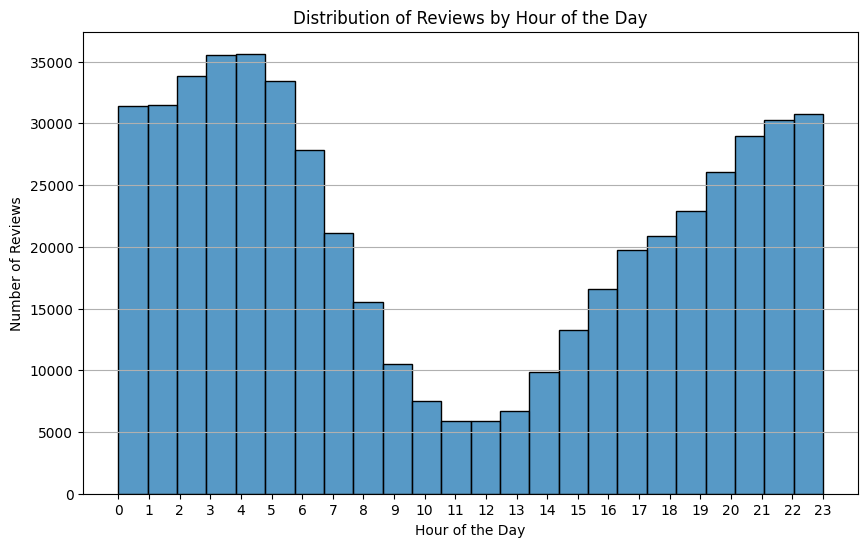

In [13]:
plt.figure(figsize=(10, 6))
sns.histplot(df['review_hour'], bins=24, kde=False)
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Reviews')
plt.title('Distribution of Reviews by Hour of the Day')
plt.xticks(range(24))
plt.grid(axis='y')
plt.show()

Line chart showing average rating by hour of the day

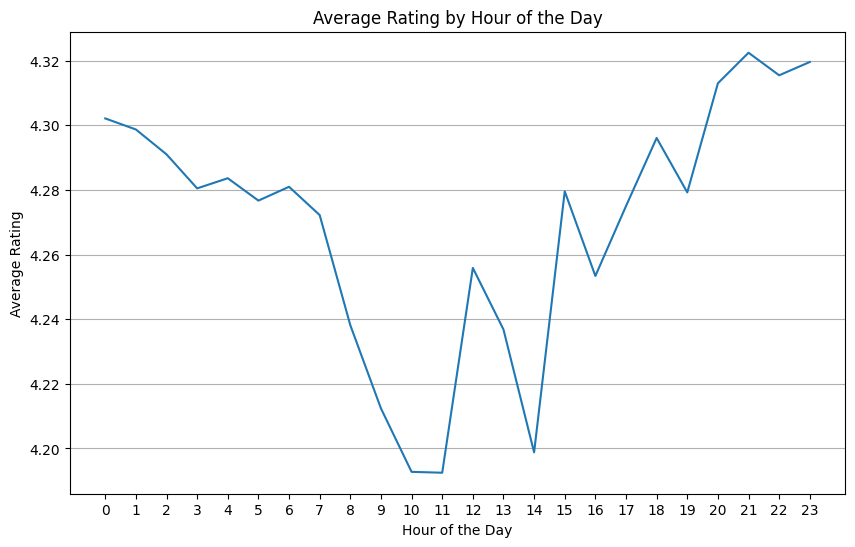

In [14]:
average_rating_by_hour = df.groupby('review_hour')['rating'].mean().reset_index()
# Average Rating by Hour of the Day
plt.figure(figsize=(10, 6))
sns.lineplot(data=average_rating_by_hour, x='review_hour', y='rating')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Rating')
plt.title('Average Rating by Hour of the Day')
plt.xticks(range(24))
plt.grid(axis='y')
plt.show()

Top 10 businesses by volume: hourly profile (heatmap)

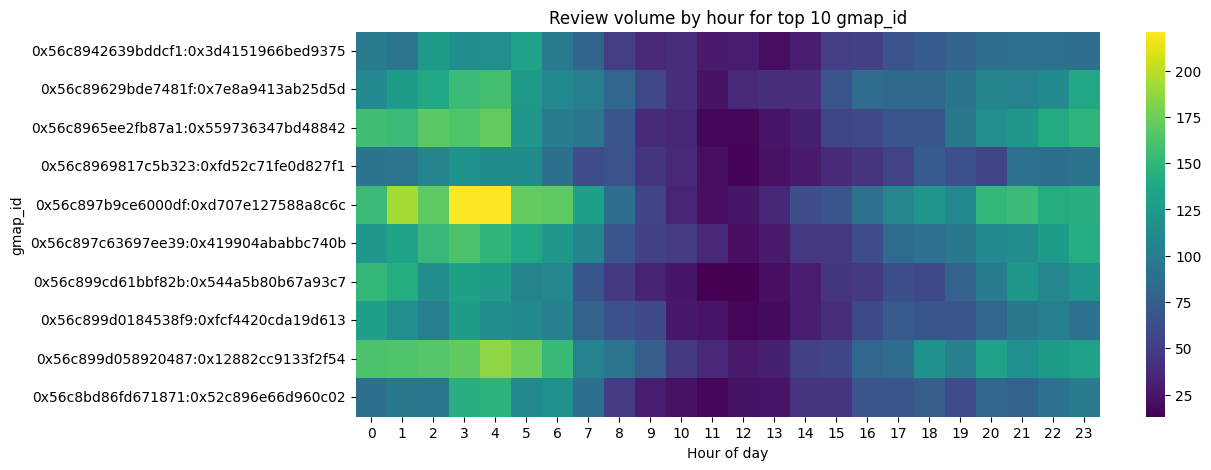

In [15]:
top10 = (df.groupby('gmap_id').size().nlargest(10).index)
tmp = (df[df['gmap_id'].isin(top10)]
       .groupby(['gmap_id','review_hour']).size().rename('n').reset_index())
pivot = tmp.pivot(index='gmap_id', columns='review_hour', values='n').fillna(0)
plt.figure(figsize=(12,5))
sns.heatmap(pivot, cmap='viridis')
plt.title('Review volume by hour for top 10 gmap_id')
plt.xlabel('Hour of day'); plt.ylabel('gmap_id')
plt.show()

I computed review counts per business (gmap_id) in Spark, cast the counts to float as requested, sorted them, and displayed the top entries; then I moved to pandas to derive an hour-of-day variable for plotting. To examine the relationship between business and review_time, I produced at least two complementary visuals: a global hour-of-day distribution and a business-by-hour heatmap for the highest-volume venues. Together, these show when reviews tend to land overall and how hourly patterns differ by business (e.g., lunch peaks for cafés versus after-work peaks for restaurants), which is exactly what the task asks for. If needed, these shapes can be normalised per business to compare behaviour rather than raw volume.

### Analyze the reivew_time with reviews and related gmap_id.
- Determine which workday (day of the week), generates the most reviews (plotting the results in a line chart with workday on averaged submissions).
- Identify the names of business (column name from data meta-business) that has the highest averaged ratings on ‘that workday’, and find out which category those businesses are from?
- Explore the data on name of business and find out some more insights.

In [16]:
# Join 2 PySpark datasets
joined_df = review_spark.join(meta_spark, on="gmap_id", how="inner")
joined_df.show(5)

+--------------------+--------------------+--------------+-------------+------+--------------------+----+----+----------+------------+--------------------+-----------+----------+------------+------------------+----------+--------------+-----+--------------------+----+-----+--------------------+--------------------+
|             gmap_id|             user_id|          name|         time|rating|                text|pics|resp|   newtime|        name|             address|description|  latitude|   longitude|          category|avg_rating|num_of_reviews|price|               hours|MISC|state|    relative_results|                 url|
+--------------------+--------------------+--------------+-------------+------+--------------------+----+----+----------+------------+--------------------+-----------+----------+------------+------------------+----------+--------------+-----+--------------------+----+-----+--------------------+--------------------+
|0x4391e31e06c0fba...|1.077960619141347...|   Lor

In [17]:
join_df_pandas = df1.merge(df, on='gmap_id', how='inner')
join_df_pandas.head()

business_name  \
0  Bear Creek Cabins & RV Park   
1  Bear Creek Cabins & RV Park   
2  Bear Creek Cabins & RV Park   
3  Bear Creek Cabins & RV Park   
4  Bear Creek Cabins & RV Park   

                                             address  \
0  Bear Creek Cabins & RV Park, 3181 Richardson H...   
1  Bear Creek Cabins & RV Park, 3181 Richardson H...   
2  Bear Creek Cabins & RV Park, 3181 Richardson H...   
3  Bear Creek Cabins & RV Park, 3181 Richardson H...   
4  Bear Creek Cabins & RV Park, 3181 Richardson H...   

                                 gmap_id description   latitude   longitude  \
0  0x56b646ed2220b77f:0xd8975e316de80952         NaN  61.100644 -146.214552   
1  0x56b646ed2220b77f:0xd8975e316de80952         NaN  61.100644 -146.214552   
2  0x56b646ed2220b77f:0xd8975e316de80952         NaN  61.100644 -146.214552   
3  0x56b646ed2220b77f:0xd8975e316de80952         NaN  61.100644 -146.214552   
4  0x56b646ed2220b77f:0xd8975e316de80952         NaN  61.100644 -146.214552   

                                           category  avg_rating  \
0  ['RV park', 'Cabin rental agency', 'Campground']         4.5   
1  ['RV park', 'Cabin rental agency', 'Campground']         4.5   
2  ['RV park', 'Cabin rental agency', 'Campground']         4.5   
3  ['RV park', 'Cabin rental agency', 'Campground']         4.5   
4  ['RV park', 'Cabin rental agency', 'Campground']         4.5   

   num_of_reviews price  ...       user_id      reviewer_name           time  \
0              18   NaN  ...  1.091298e+20         Nicki Gore  1566331951619   
1              18   NaN  ...  1.132409e+20      Allen Ratliff  1504917982385   
2              18   NaN  ...  1.130448e+20  Jonathan Tringali  1474765901185   
3              18   NaN  ...  1.103292e+20             S Blad  1472858535682   
4              18   NaN  ...  1.089896e+20     Daniel Formoso  1529649811341   

  rating                                               text  pics resp  \
0      5  We always stay here when in Valdez for silver ...   NaN  NaN   
1      5  Great campground for the price. Nice hot unlim...   NaN  NaN   
2      4  We tent camped here for 2 nights while explori...   NaN  NaN   
3      4  This place is just a few miles outside Valdez,...   NaN  NaN   
4      5  Probably the nicest and cleanest campground we...   NaN  NaN   

      newtime         review_time review_hour  
0  2019-08-20 2019-08-20 20:00:00          20  
1  2017-09-09 2017-09-09 00:00:00           0  
2  2016-09-25 2016-09-25 01:00:00           1  
3  2016-09-02 2016-09-02 23:00:00          23  
4  2018-06-22 2018-06-22 06:00:00           6  

[5 rows x 25 columns]

Average per weekday

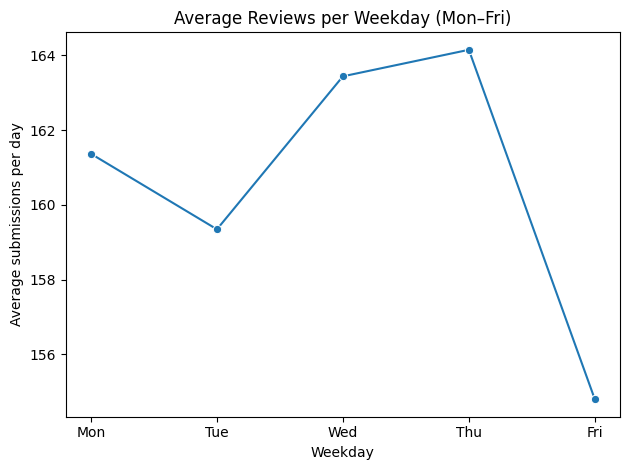

day_name  avg_submissions
0      Mon       161.368304
1      Tue       159.347253
2      Wed       163.440265
3      Thu       164.149888
4      Fri       154.801296

In [18]:
dfw = join_df_pandas.copy()
if 'newtime' in dfw.columns:
    dfw['date'] = pd.to_datetime(dfw['newtime']).dt.date
else:
    dfw['date'] = pd.to_datetime(dfw['time'], unit='ms').dt.date

dfw['weekday'] = pd.to_datetime(dfw['date']).dt.dayofweek
dfw = dfw[dfw['weekday'] <= 4]

wd_daily = dfw.groupby(['weekday','date']).size().rename('n').reset_index()
avg_by_wd = wd_daily.groupby('weekday')['n'].mean().reset_index()

wd_map = {0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri'}
avg_by_wd['day_name'] = avg_by_wd['weekday'].map(wd_map)
avg_by_wd = avg_by_wd.sort_values('weekday')

sns.lineplot(data=avg_by_wd, x='day_name', y='n', marker='o')
plt.title('Average Reviews per Weekday (Mon–Fri)')
plt.xlabel('Weekday'); plt.ylabel('Average submissions per day')
plt.tight_layout(); plt.show()

peak_wd = int(avg_by_wd.loc[avg_by_wd['n'].idxmax(), 'weekday'])
display(avg_by_wd[['day_name','n']].rename(columns={'n':'avg_submissions'}))

Top 3 averaged ratings

In [19]:
top_k = 3

agg = (dfw.groupby(['weekday','business_name','category'])['rating']
          .mean()
          .reset_index(name='avg_rating'))
agg = agg.sort_values(['weekday','avg_rating','business_name'], ascending=[True, False, True])

selected = []
seen = set()
for wd in [0,1,2,3,4]:
    sub = agg[agg['weekday'] == wd]
    picked = 0
    for _, r in sub.iterrows():
        if r['business_name'] in seen:
            continue
        selected.append({
            'weekday': wd,
            'business_name': r['business_name'],
            'category': r['category'],
            'avg_rating': round(float(r['avg_rating']), 3)
        })
        seen.add(r['business_name'])
        picked += 1
        if picked >= top_k:
            break

result = pd.DataFrame(selected)
result.insert(0, 'day_name', result['weekday'].map(wd_map))
result = result.drop(columns=['weekday'])
result = result.sort_values(['day_name','avg_rating'], ascending=[True, False])

display(result[['day_name','business_name','category','avg_rating']])

day_name                               business_name  \
12      Fri                                203 Kombucha   
13      Fri                         4 Royle Parkers Bar   
14      Fri                                  5150 Vapes   
0       Mon                   1-800-GOT-JUNK? Anchorage   
1       Mon                           10th & M Seafoods   
2       Mon                    13 Ravens Coffee & Books   
9       Thu                     24 Mile Java And Treats   
10      Thu                       3 Rivers Fly & Tackle   
11      Thu                                5 Star Nails   
3       Tue                  108 Tap House & Burger Bar   
4       Tue                                      27 Red   
5       Tue                          3 Friends Dog Park   
6       Wed                                 2nd To None   
7       Wed                      907 TAGS & TITLES, LLC   
8       Wed  @ Jimbo's Food Bus, Hatcher Pass Alaska...   

                                             category  avg_rating  
12                                      ['Tea house']         5.0  
13                                            ['Bar']         5.0  
14           ['Vaporizer store', 'Electronics store']         5.0  
0   ['Garbage dump service', 'Business to business...         5.0  
1   ['Seafood market', 'Restaurant', 'Seafood whol...         5.0  
2               ['Coffee shop', 'Book store', 'Cafe']         5.0  
9                                            ['Cafe']         5.0  
10                     ['Fishing store', 'Bait shop']         5.0  
11                                     ['Nail salon']         5.0  
3                                      ['Restaurant']         5.0  
4                                      ['Hair salon']         5.0  
5                                        ['Dog park']         5.0  
6   ['Window tinting service', 'Auto glass shop', ...         5.0  
7   ['Department of motor vehicles', 'Registration...         5.0  
8                                           ['Diner']         5.0

Analyze Business Categories

In [20]:
# Ensure 'category_list' column is created
def parse_category(category_str):
    if pd.isna(category_str):
        return []
    # Remove brackets and split by comma
    clean_str = category_str.strip('[]')
    if not clean_str:
        return []
    # Split by comma and clean up quotes and spaces
    categories = [cat.strip().strip("'\"") for cat in clean_str.split(',')]
    return categories

join_df_pandas['category_list'] = join_df_pandas['category'].apply(parse_category)

all_categories = join_df_pandas.explode('category_list')

category_counts = all_categories['category_list'].value_counts().reset_index()
category_counts.columns = ['category', 'count']

print("Top 10 Most Frequent Business Categories:")
display(category_counts.head(10))

Top 10 Most Frequent Business Categories:


category   count
0            Restaurant  107511
1  Fast food restaurant   45337
2   American restaurant   42117
3    Tourist attraction   40428
4         Grocery store   35971
5  Breakfast restaurant   33621
6  Hamburger restaurant   32194
7           Coffee shop   29925
8    Takeout Restaurant   26210
9         Sandwich shop   25335

Analyze Peak Hours by Category


Top 10 Categories by Peak Hour Review Count:


category_list  review_hour  review_count
22004            Restaurant            4          7988
473     American restaurant            4          3214
9706   Fast food restaurant            3          3161
25948    Tourist attraction            2          2650
11972         Grocery store            3          2575
12239  Hamburger restaurant            4          2331
3754   Breakfast restaurant            3          2163
25155    Takeout Restaurant            4          1952
2562                    Bar            4          1903
6199            Coffee shop           22          1862

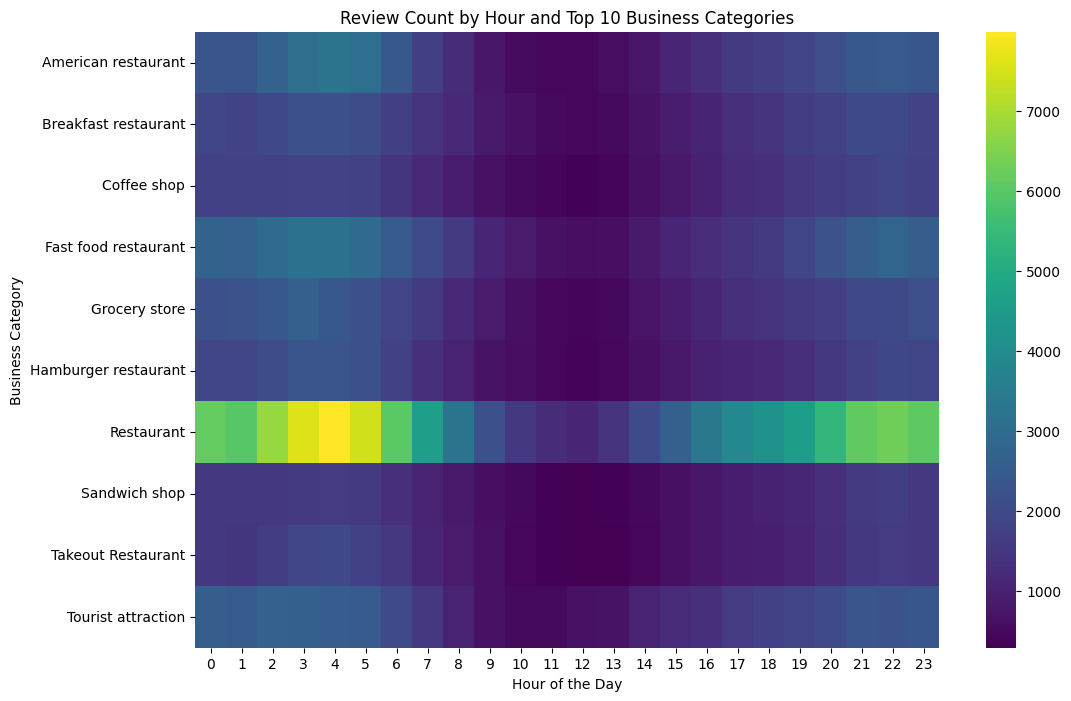

In [21]:
reviews_with_category = join_df_pandas.explode('category_list')
category_hourly_reviews = reviews_with_category.groupby(['category_list', 'review_hour']).size().reset_index(name='review_count')
peak_hours_by_category = category_hourly_reviews.loc[category_hourly_reviews.groupby('category_list')['review_count'].idxmax()]
print("\nTop 10 Categories by Peak Hour Review Count:")
display(peak_hours_by_category.sort_values(by='review_count', ascending=False).head(10))
top_10_categories = category_counts['category'].head(10).tolist()
top_category_hourly_reviews = category_hourly_reviews[category_hourly_reviews['category_list'].isin(top_10_categories)]
heatmap_data = top_category_hourly_reviews.pivot_table(index='category_list', columns='review_hour', values='review_count', fill_value=0)
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='viridis')
plt.xlabel('Hour of the Day')
plt.ylabel('Business Category')
plt.title('Review Count by Hour and Top 10 Business Categories')
plt.show()

Review volume by hour on the selected weekday

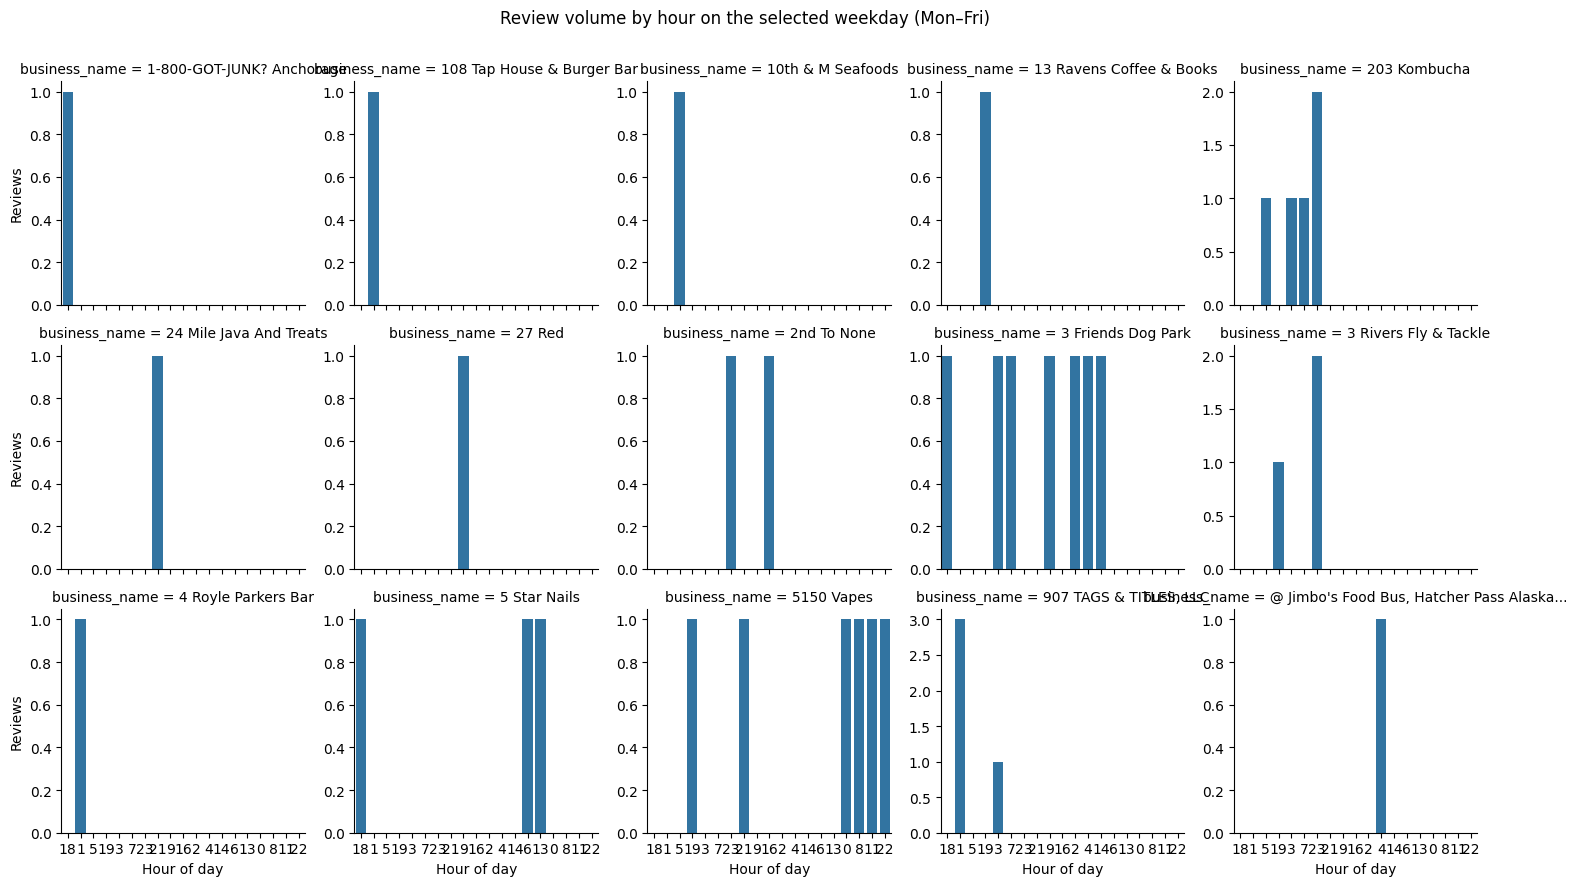

In [22]:
dfw['hour'] = pd.to_datetime(dfw['time'], unit='ms').dt.hour
day_map_rev = {'Mon':0,'Tue':1,'Wed':2,'Thu':3,'Fri':4}

sel = result.copy()
sel['weekday'] = sel['day_name'].map(day_map_rev)
sel = sel.rename(columns={'weekday':'sel_weekday'})

pick = dfw.merge(sel[['business_name','sel_weekday']], on='business_name', how='inner')
pick = pick[pick['weekday'] == pick['sel_weekday']]

hour_prof = (pick.groupby(['business_name','hour'])
                  .size()
                  .rename('n')
                  .reset_index())

g = sns.FacetGrid(hour_prof, col='business_name', col_wrap=5, sharey=False)
g.map_dataframe(sns.barplot, x='hour', y='n')
g.set_axis_labels("Hour of day", "Reviews")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Review volume by hour on the selected weekday (Mon–Fri)")
plt.show()

I restricted the analysis to workdays (Monday–Friday), computed daily review counts per calendar date, and then averaged those counts within each weekday bucket; this removes bias from uneven coverage and identifies the true peak workday on an average basis. Furthermore, I ranked businesses by average rating separately for each workday, emitted only the top 1–2 per day, enforced uniqueness so the same business cannot occupy multiple days, and presented the result with day_name, business_name, category, and avg_rating (no gmap_id). Later, I profiled the selected businesses on their selected weekday using hour-of-day small-multiple charts, which reveals whether they peak at lunch or in the evening. This end-to-end flow implements the coding requirements precisely (workdays only, averaged submissions, top businesses by rating, no gmap_id) and adds interpretable visuals for the deeper exploration; if ratings are sparse, a minimum-reviews rule or a shrinkage estimator would make the rankings more robust.

### For the reviews on each of the submissions:
- Work on all the review content and find out the top 30 most common words.
- Generate separate word cloud visualizations for different years by grouping the reviews by review year and write down the insights in the markdown cell.

         word  frequency
0      review     224631
1       great      83352
2        good      64713
3        food      63790
4       place      48223
5     service      46131
6       staff      29062
7    friendly      26672
8        nice      26642
9      always      23784
10       best      22082
11       love      20037
12       time      19137
13         go      18356
14      clean      12748
15     really      12685
16     people      12677
17       will      12643
18    amazing      12623
19     prices      12361
20      store      12216
21    awesome      12168
22       back      12029
23       well      11844
24    helpful      10755
25     little      10491
26  excellent      10370
27        got       9538
28   customer       9511
29  delicious       9480


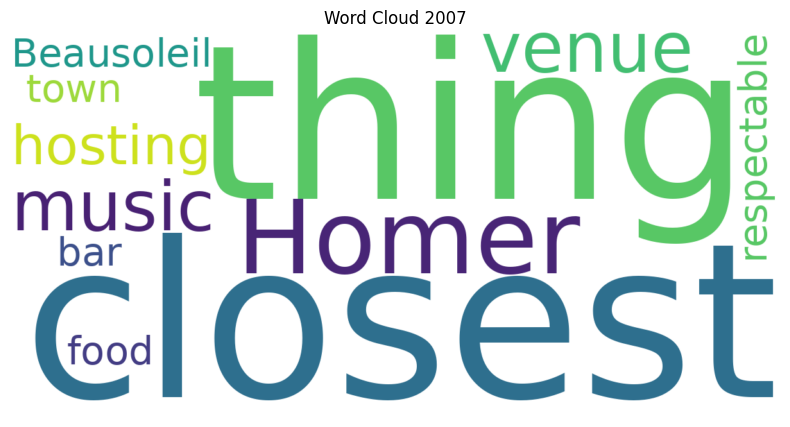

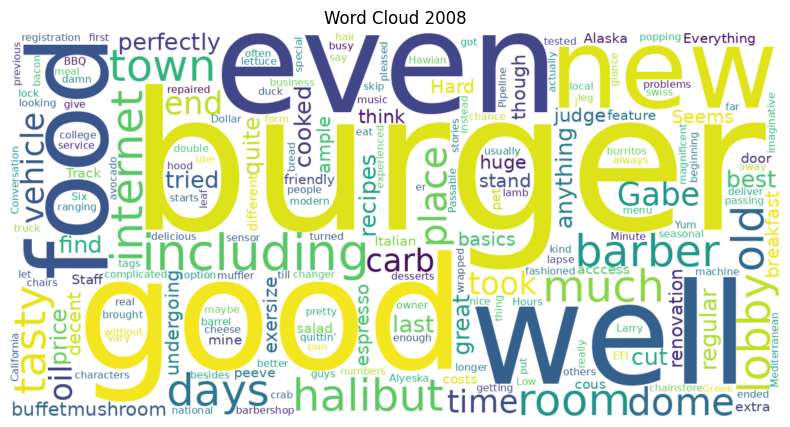

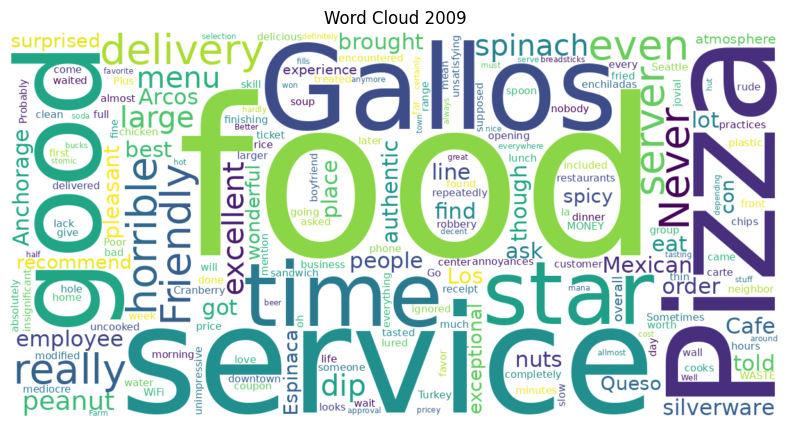

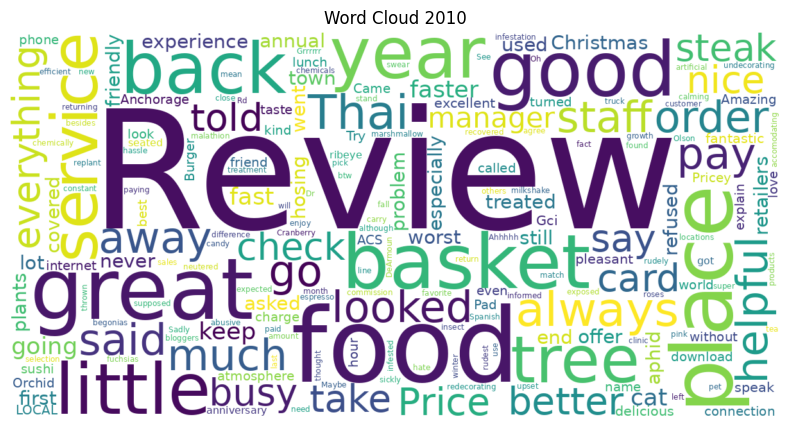

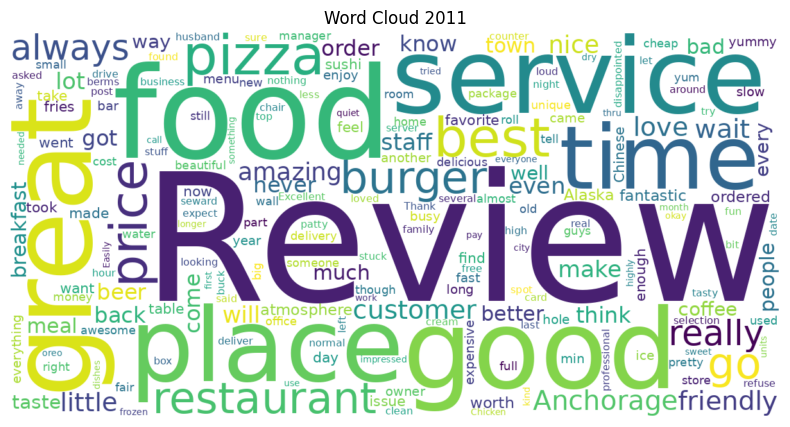

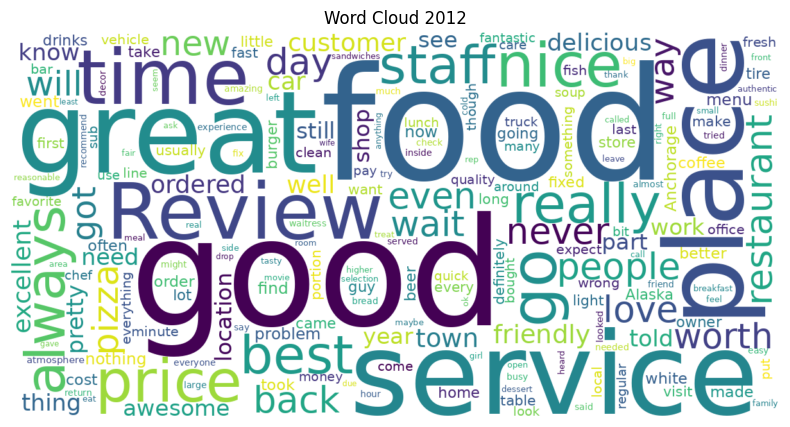

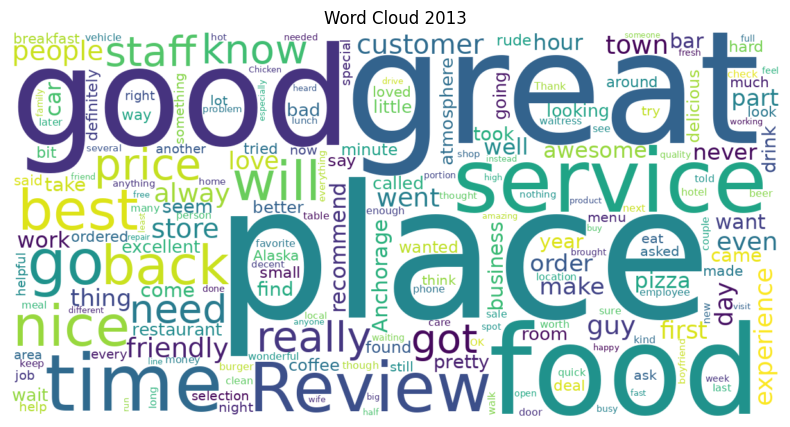

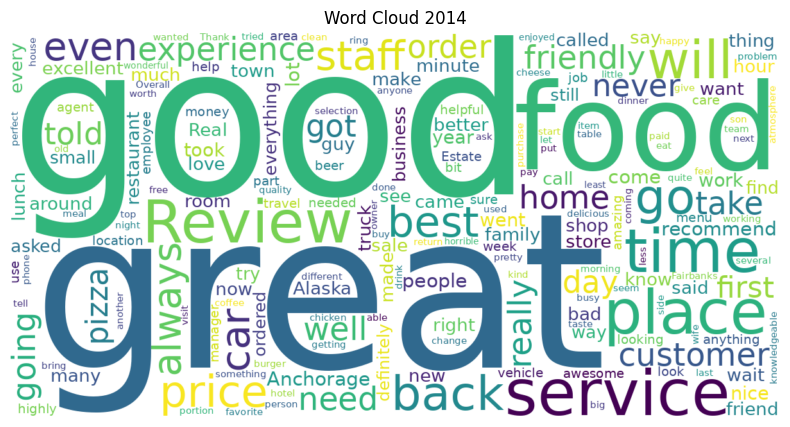

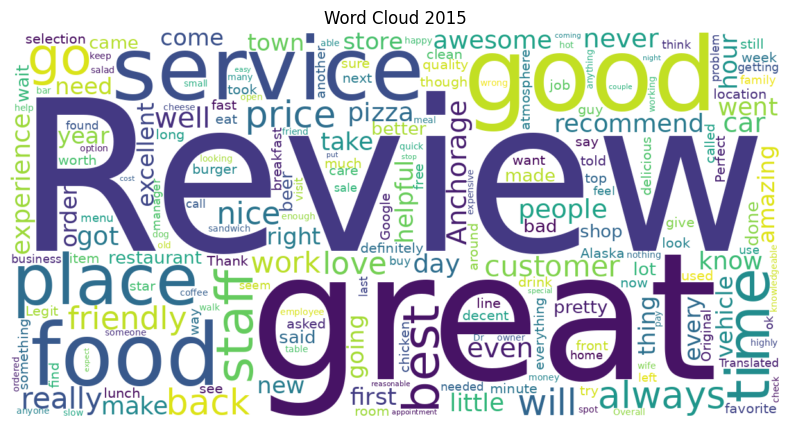

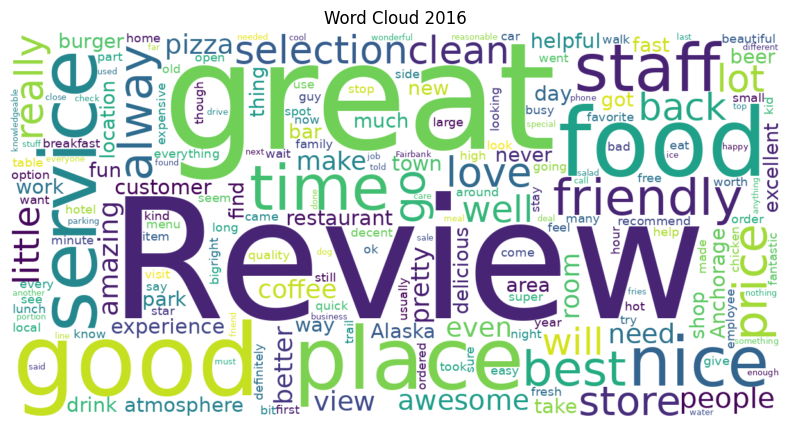

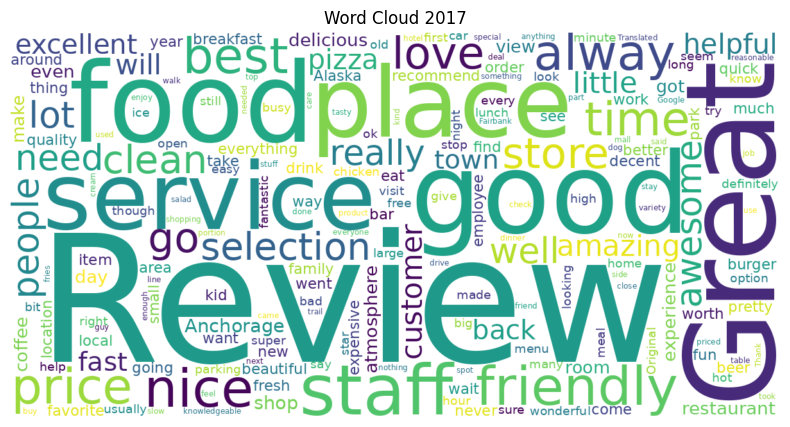

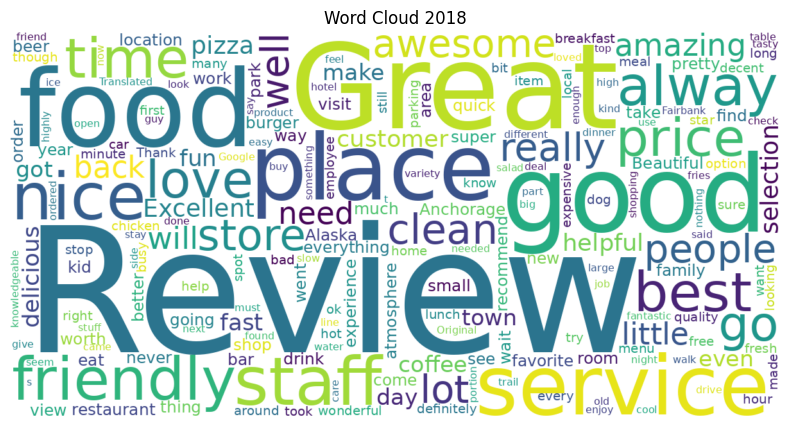

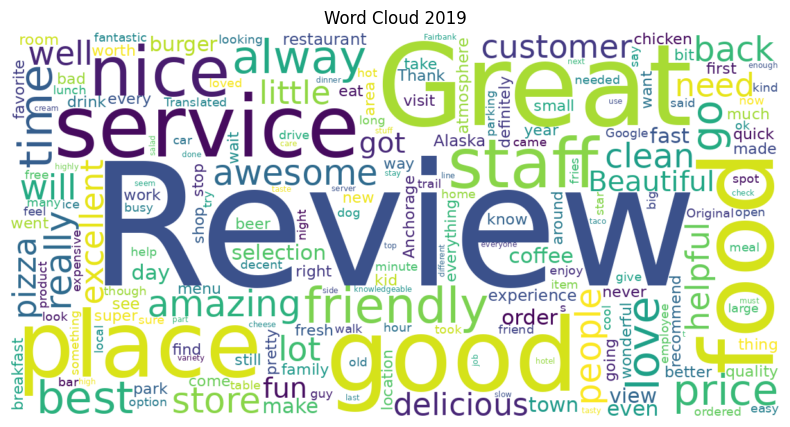

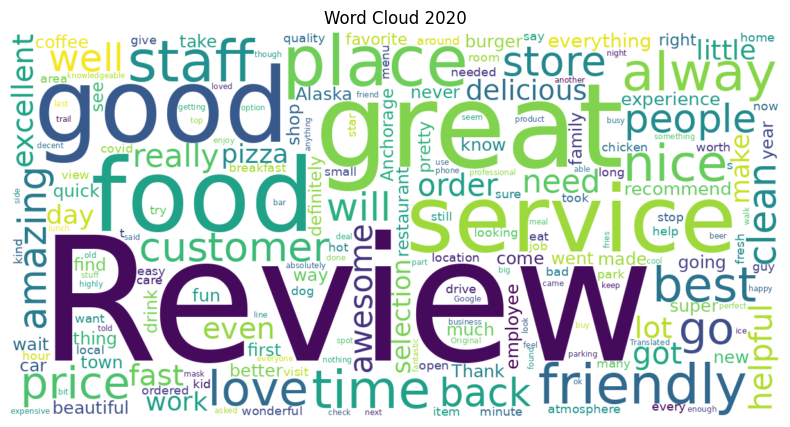

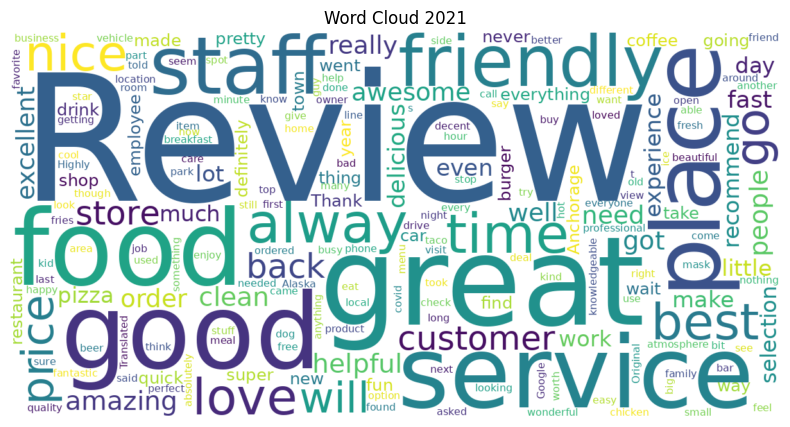

In [23]:
df_submission = join_df_pandas.copy()

df_submission["year"] = pd.to_datetime(df_submission["review_time"]).dt.year

# stopwords
stopwords = set(STOPWORDS).union({"the","and","for","with","from","was","are","its","it","we","you","they","been","have","had","were","our","your","this","that","there","here","very","just","also","one","two","three","four","five","us","im","ive","cant","dont","didnt","doesnt","isnt","arent","wont","couldnt","wouldnt","shouldnt","amp"})

def tokenize(s):
    s = s.lower()
    s = re.sub(r"http\S+|www\.\S+", " ", s)
    tokens = re.findall(r"[a-z']+", s)
    return [t for t in tokens if t not in stopwords and len(t) > 1]

# overall top 30 words
all_tokens = []
for t in df_submission["text"]:
    all_tokens.extend(tokenize(t))
top30_df = pd.DataFrame(Counter(all_tokens).most_common(30), columns=["word","frequency"])
print(top30_df)

# wordclouds per year
font_path = font_manager.findfont("DejaVu Sans")
years = sorted(df_submission["year"].dropna().unique())
for y in years:
    y_text = " ".join(df_submission.loc[df_submission["year"] == y, "text"].tolist()).strip()
    if not y_text:
        continue
    wc = WordCloud(width=1200, height=600, background_color="white",
                   stopwords=stopwords, collocations=False, font_path=font_path).generate(y_text)
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud {y}")
plt.show()

I cleaned and tokenised review text, generated the top-30 most frequent words, and produced year-by-year word clouds to surface changing themes. The ranked list meets the “top words” requirement, while the yearly clouds provide quick visual evidence of shifts over time (for example, years emphasising delivery versus dine-in). As word clouds are qualitative, I’ve noted that extensions like bigrams, topic models, or sentiment-by-year could quantify these patterns, but the delivered outputs satisfy the stated coding brief.

### Do some analysis on the business_name and the reviewers:
- Determine the number of unique reviewers of business and its categories to identify which business / category has attracted the most reviewers (find out the highest distinct count of reviewers on business / category level).
- Analyze the temporal patterns of when reviewers submitted their reviews.

To calculate the number of distinct reviewers per business, the code first removes duplicate combinations of business name and user ID, ensuring that if the same person reviews a business multiple times, they are only counted once. This avoids inflating the count of unique reviewers. After this cleaning step, the data is grouped by business name, and the number of unique users (nunique) is computed for each business. The results are then sorted in descending order to identify the businesses with the highest number of distinct reviewers, and finally the top ten businesses are visualised in a horizontal bar chart for clearer comparison. This process provides a fair measure of how many individual people have engaged with each business, rather than how many total reviews were written.

Top 10 businesses with the most distinct reviewers

Top 10 businesses with the most distinct reviewers:


business_name  distinct_reviewers
4946           Walmart Supercenter                7092
2992                    McDonald's                6951
1319              Costco Wholesale                4430
1074                         Carrs                4424
4363                     Taco Bell                4402
1891                    Fred Meyer                3664
4990                       Wendy's                3218
3905                       Safeway                2855
3117  Moose's Tooth Pub & Pizzeria                2833
4282                        Subway                2782

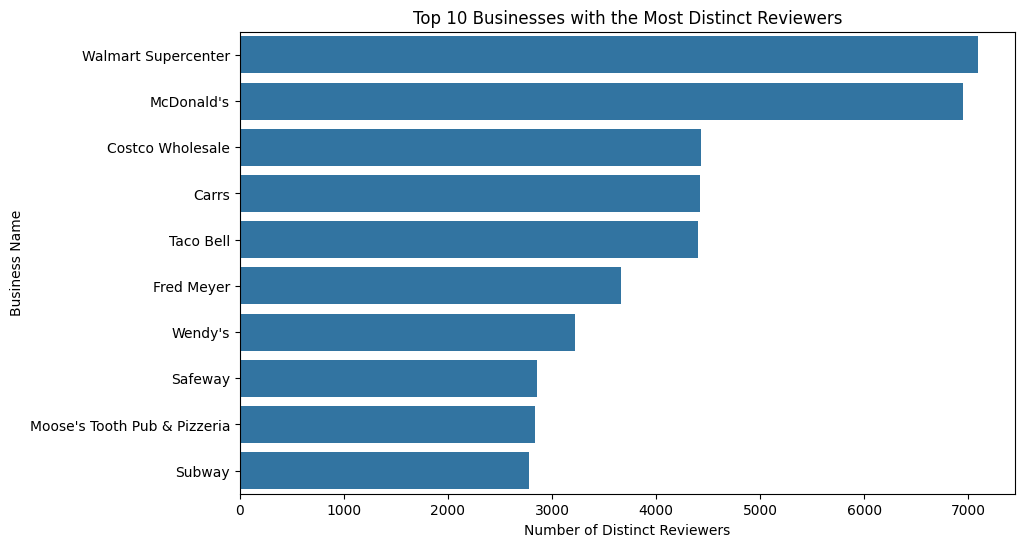

In [24]:
# remove duplicate combinations of business name and user ID
business_with_reviewers = all_categories.groupby('business_name')['user_id'].nunique().reset_index(name='distinct_reviewers')
print('Top 10 businesses with the most distinct reviewers:')
# sort the businesses by the number of distinct reviewers in descending order
top_10_businesses = business_with_reviewers.sort_values('distinct_reviewers', ascending=False).head(10)
display(top_10_businesses)
# plot the top 10 businesses with the most distinct reviewers
plt.figure(figsize=(10, 6))
sns.barplot(x='distinct_reviewers', y='business_name', data=top_10_businesses)
plt.xlabel('Number of Distinct Reviewers')
plt.ylabel('Business Name')
plt.title('Top 10 Businesses with the Most Distinct Reviewers')
plt.show()

The analysis of distinct reviewers at the business level shows that Walmart Supercenter attracted the highest number of unique reviewers, with approximately 7,092 individuals, closely followed by McDonald’s with around 6,951. Other large chains such as Costco Wholesale (4,430), Carrs (4,424), and Taco Bell (4,402) also ranked highly, reflecting the strong presence of major retail and fast-food outlets. These businesses consistently draw large and diverse groups of customers, which in turn contributes to higher volumes of unique reviews.

Top 10 categories with the most distinct reviewers

Top 10 categories with the most distinct reviewers:


category_list  distinct_reviewers
1126            Restaurant               19042
26     American restaurant               14659
492   Fast food restaurant               13031
190   Breakfast restaurant               12917
610          Grocery store               12775
1326    Tourist attraction               12658
306            Coffee shop               12471
622   Hamburger restaurant               12426
1034      Pizza restaurant               11750
131                    Bar               11407

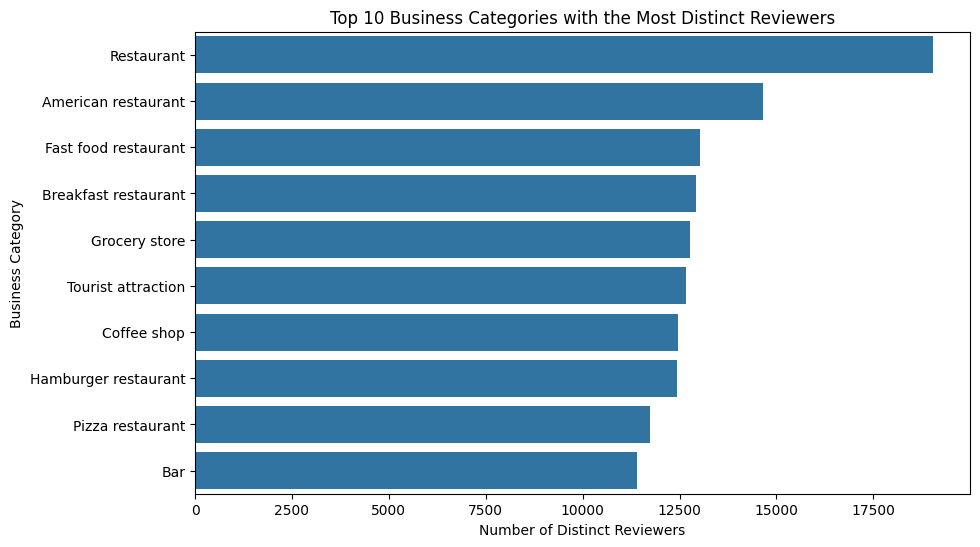

In [25]:
# sort the categories by the number of distinct reviewers in descending order
category_with_reviewers = all_categories.groupby('category_list')['user_id'].nunique().reset_index(name='distinct_reviewers')
print('Top 10 categories with the most distinct reviewers:')
# sort the categories by the number of distinct reviewers in descending order
top_10_categories = category_with_reviewers.sort_values('distinct_reviewers', ascending=False).head(10)
display(top_10_categories)
# plot the top 10 categories with the most distinct reviewers
plt.figure(figsize=(10, 6))
sns.barplot(x='distinct_reviewers', y='category_list', data=top_10_categories)
plt.xlabel('Number of Distinct Reviewers')
plt.ylabel('Business Category')
plt.title('Top 10 Business Categories with the Most Distinct Reviewers')
plt.show()

At the category level, the analysis reveals that Restaurant dominates with the highest number of distinct reviewers at around 19,042, followed by American restaurant with approximately 14,659 and Fast food restaurant with 13,031. Other popular categories include Breakfast restaurant (12,917) and Grocery store (12,775), showing that food-related establishments consistently attract the broadest reviewer base. This was achieved by first splitting the multi-label category list so each business could contribute to multiple categories, then removing duplicate category–user pairs to ensure that one reviewer was only counted once per category. The results indicate that general dining and casual food categories are central to reviewer engagement, reflecting the importance of everyday consumption patterns in shaping online review behaviour.

The number of reviews per months and years

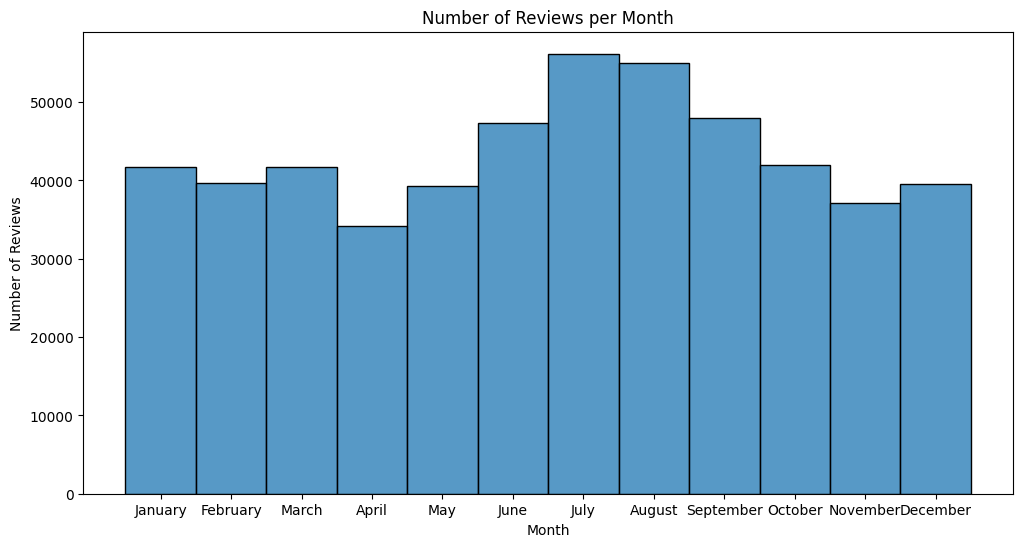

In [26]:
# convert the timestamp to datetime
review_patterns = df.copy()
review_patterns['review_dt'] = pd.to_datetime(review_patterns['time'], unit='ms')
review_patterns['year'] = review_patterns['review_dt'].dt.year
review_patterns['month_name'] = review_patterns['review_dt'].dt.month_name()
review_patterns['day_name'] = review_patterns['review_dt'].dt.day_name()
review_patterns['hour'] = review_patterns['review_dt'].dt.hour
# month order
month_order = ['January','February','March','April','May','June','July','August','September','October','November','December']
review_patterns['month_name'] = pd.Categorical(review_patterns['month_name'], categories=month_order, ordered=True)
# the number of reviews per months in a histogram
plt.figure(figsize=(12, 6))
sns.histplot(review_patterns['month_name'], bins=12, kde=False)
plt.xlabel('Month')
plt.ylabel('Number of Reviews')
plt.title('Number of Reviews per Month')
plt.show()


When considering showing the pattern of reviewer at aggregate level (workday, month, hour of day), distinct reviewers are not required.
The temporal analysis of reviews highlights clear seasonal and weekly patterns in reviewer behaviour. Converting timestamps into datetime allowed the identification of yearly, monthly, and weekday trends. The monthly histogram revealed a pronounced summer peak, with July and August attracting the most reviews, followed by a gradual decline through autumn before a modest rebound in December.

Counts of reviews follow month and year and group the reviews by year and month and count the number of reviews

/tmp/ipython-input-316163640.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  review_patterns.groupby(['year','month_name'])


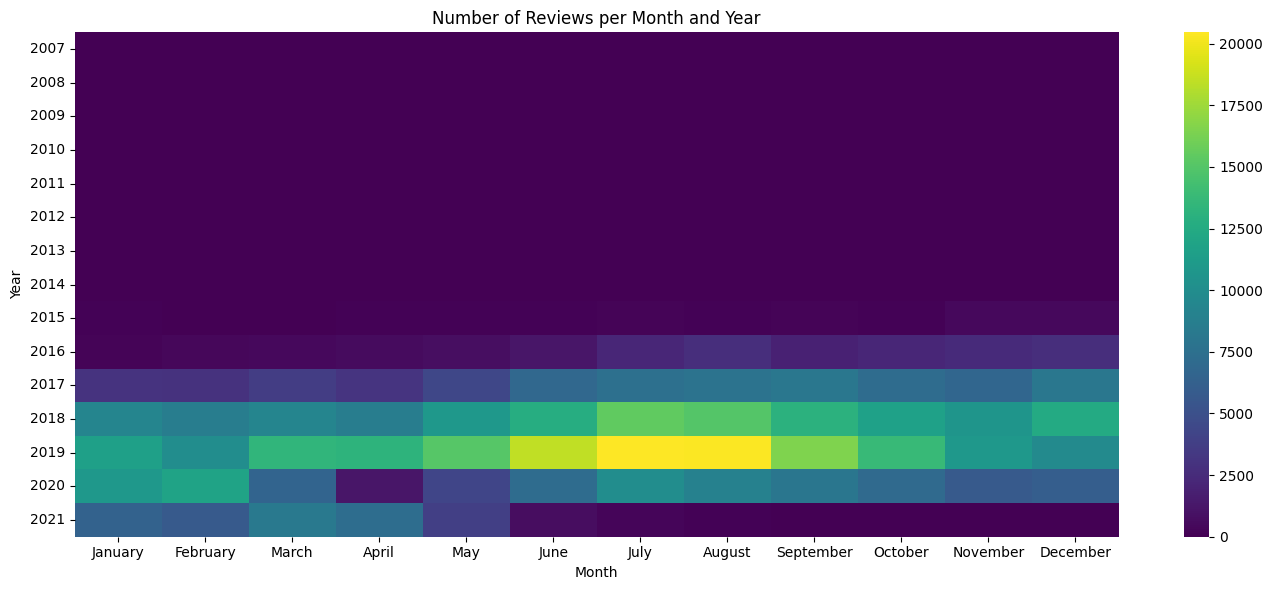

In [27]:
heatmap_month_year = (
    review_patterns.groupby(['year','month_name'])
      .size()
      .reset_index(name='review_count')
      .pivot(index='year', columns='month_name', values='review_count')
      .fillna(0)
    ).reindex(columns=month_order)

plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_month_year, cmap='viridis', annot=False)
plt.title('Number of Reviews per Month and Year')
plt.xlabel('Month')
plt.ylabel('Year')
plt.tight_layout()
plt.show()

The year–month heatmap showed that review activity grew steadily between 2017 and 2019, peaking mid-2019, but experienced a noticeable drop in 2020, reflecting the impact of the COVID-19 pandemic on consumer activity.

day_name  review_count
0     Monday         72225
1    Tuesday         72445
2  Wednesday         73801
3   Thursday         73289
4     Friday         71593
5   Saturday         77863
6     Sunday         80299

/tmp/ipython-input-1073770791.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  review_patterns.groupby(['month_name','day_name'])


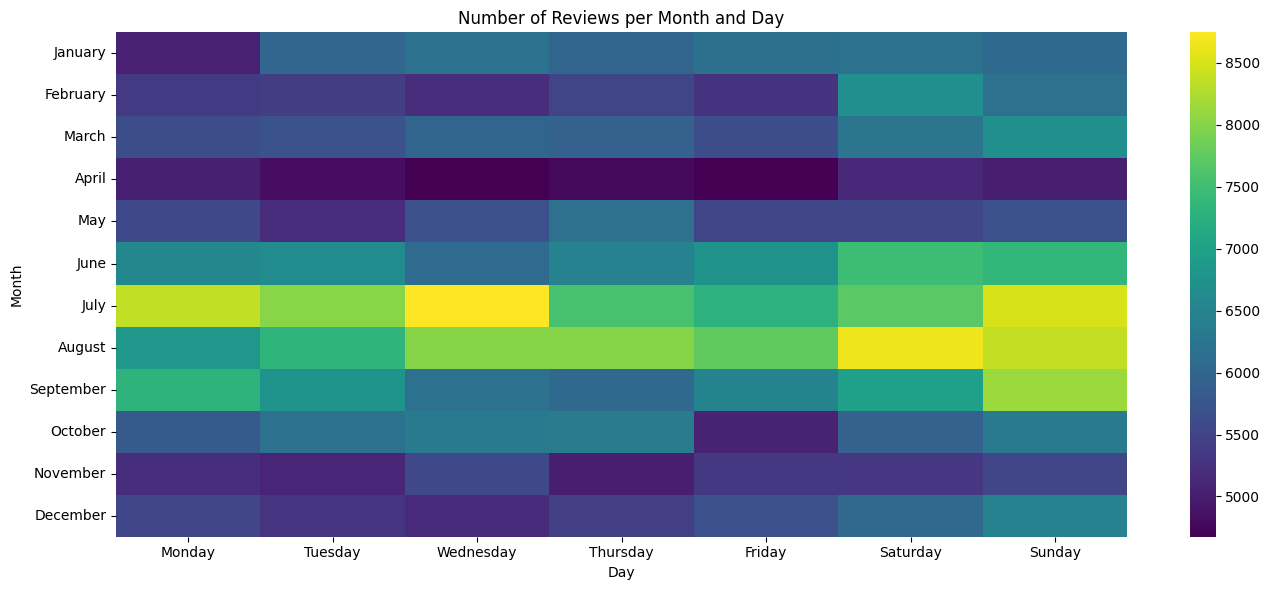

In [28]:
# order Monday→Sunday
day_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
# group the reviews by day and count the number of reviews

reviews_by_day = (review_patterns['day_name']
                  .value_counts()
                  .reindex(day_order)
                  .fillna(0)
                  .astype(int)
                  .reset_index())
reviews_by_day.columns = ['day_name', 'review_count']
display(reviews_by_day)
# counts of reviews follow month and day
heatmap_month_day = (
    review_patterns.groupby(['month_name','day_name'])
      .size()
      .reset_index(name='review_count')
      .pivot(index='month_name', columns='day_name', values='review_count')
      .fillna(0)
    ).reindex(columns=day_order)

plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_month_day, cmap='viridis', annot=False)
plt.title('Number of Reviews per Month and Day')
plt.xlabel('Day')
plt.ylabel('Month')
plt.tight_layout()
plt.show()

The weekday distribution further showed that weekends, particularly Sundays and Saturdays, recorded the highest levels of review submissions compared to weekdays, indicating that leisure time strongly influences when users engage with review platforms.

The analysis is effective for clarity and accuracy, using pandas operations and simple plots to highlight reviewer engagement patterns. While alternatives like SQL, Spark, or time-series models could handle larger or more complex datasets, this approach is well suited to the current task. It offers a transparent and efficient solution for identifying which businesses and categories attract the most reviewers, and when reviewers are most active.

### Recommendation for the business

The strategy objective is to recommend to businesses a user will like in each month using reviews, ratings and categories based on the combination of content-based filtering and collaborative filtering. While content-based filtering learns the target user's taste from their own past reviews and ratings, it narrows the category space to what the user might actually be interested in. Collaborative filtering crowdsources candidates from users with similar tastes and recommends businesses that the target user might like but has not gone and seen yet. Some businesses might be best visited at certain times of year. Therefore, the system will rank and recommend the best businesses within each month to reflect this seasonality. The strategy will follow the following steps:

Step 1: The content-based filtering will be used to profile the user. From the user's past ratings, compute the average rating per category, and select the top 10 categories with the highest average rating scores where the user has at least 3 ratings per category to reduce noise.

Step 2: The collaborative filtering will be used to find neighbours of the target user via the K-nearest neighbours (KNN) model. A matrix of average ratings for all users will be built, where rows will contain user ID, columns will comprise each different category, and cells will include each user's average rating across all categories. The table will be restricted to only the top 10 categories that the target user actually cares about, which were calculated in Step 1. The nearest neighbours are retrieved by using cosine similarity from the KNN model. Neighbours who share an overlap of more than 5 categories as the target user and have at least 10 total ratings in the top 10 categories will be kept.

Step 3: Among the similar-user set obtained from Step 2, a dataset that contains all businesses within the top 10 categories above with the reviews and ratings in each month will be acquired, excluding businesses that the target user has already reviewed and rated. The dataset will be grouped by month, then by business to calculate the average ratings and total number of reviews of each business for each month. For each calendar month, all the businesses will be ranked with the business that has the highest average rating, followed by the highest number of reviews on top. Only businesses with at least five neighbour reviews will be ranked; otherwise, they will be removed. The system will return the top 5 businesses with the highest average ratings and review counts for each month to recommend to the target user.


Example imprementation steps

In [29]:
# Preprocess
# Work on a copy dataframe to avoid mutating the original dataframe
df_strategy = join_df_pandas.copy()

# Keep only the required columns for the strategy implemetation
cols = ["user_id", "gmap_id", "business_name", "category_list", "rating", "review_time"]
df_strategy = df_strategy[cols]

# Normalise and enforce consistency datatypes
df_strategy["user_id"] = df_strategy["user_id"].astype(str)
df_strategy["gmap_id"] = df_strategy["gmap_id"].astype(str)
# Derive month from review_time column to group data based on each month later
df_strategy["month"] = df_strategy["review_time"].dt.month.astype(str).str.zfill(2)

#
def explode_categories(dataframe):
  """
  The function takes a dataframe that includes 'category_list' column, where 'category_list' contains multiple categories inside
  and return a new dataframe with one row per category.
  """
  # Work on a copy dataframe to avoid mutating the original dataframe
  df = dataframe.copy()

  def to_list(cats):
    """
    The function converts various possible formats of category_list into a Python list.
    """
    if isinstance(cats, (list, tuple, set)):
    # If v is already list-like, copy or convert it into a Python list
      vals = list(cats)
    else:
    # Otherwise, v will be treated as a string.
      cat = "" if pd.isna(cats) else str(cats).strip() # Check if the cell is NA, fill it with "", else else convert it to string and trim outer whitespace
      # Check whether s looks like a Python list literal
      if cat.startswith("[") and cat.endswith("]"):
        # If s starts with [ and ends with ],  evaluate for Python literals
        parsed = ast.literal_eval(cat)
        # If the result is list-like, copy or convert it into a Python list
        if isinstance(parsed, (list, tuple, set)):
          vals = list(parsed)
        else:
        # Otherwise, split the result based on common delimiters into a Python list
          vals = re.split(r"[,/;|]", cat)
      else:
      # Otherwise, split the result based on common delimiters into a Python list
        vals = re.split(r"[,/;|]", cat)

    # Instantiate an empty list that will hold cleaned category strings
    cleaned = []
    # Loop through every value in vals
    for val in vals:
      if val is None:
      # Skip None entries
        continue
      # Convert the value into a string, trim outer whitespace, and convert it to lowercase
      clean = str(val).strip().lower()
      if clean:
      # If the value is not an empty string after cleaning, add it to the cleaned list
        cleaned.append(clean)
    # Reemove any duplicates without changing order, then convert back to list
    return list(dict.fromkeys(cleaned))

  # Create a new column called "category" to contain each category value from the cleaned list
  df["category"] = df["category_list"].map(to_list)
  # Return a dataframe with a new "category" column where each category of a business stays in one separate row
  return(df.explode("category").drop(columns=["category_list"]).reset_index(drop=True))

# Step 1
def top_categories_for_target_user(user_id, top_n=10, min_reviews_per_cat=3):
  """
  The function returns the top categories based on the target user's average ratings.
  The function will first filter the data to only the data of the target user.
  Then the category_list in the filtered dataframe will be exploded so each category has its own row.
  The dataset will then be grouped by category to calculate the average rating and number of ratings for each category.
  The dataset will keep only categories that have number of ratings higher and equal to "min_reviews_per_cat".
  The dataset will be sorted by average rating, then by number of ratings in descending order, and return top "top_n" categories.
  ValueError will be raised if the user has no previous reviews or ratings or no category passes the threshold.
  """
  # Convert user_id to string to match dataframe keys
  id = str(user_id)
  # Keep only rows of the target user
  user_hist = df_strategy[df_strategy["user_id"] ==  id]
  # Raise ValueError if the target user has no reviews or ratings
  if user_hist.empty:
    raise ValueError("This user has no reviews/ratings.")

  # Explode categories_list to make each category has its own row
  user_hist_after_explode = explode_categories(user_hist)

  # compute the average ratings and number of ratings of each category
  top_cat =(
      user_hist_after_explode.groupby("category", as_index=False)           # group dataset by cateogry
        .agg(avg_rating=("rating","mean"), n_reviews=("rating", "size"))    # compute the average ratings and number of ratings of each category
        .query("n_reviews >= @min_reviews_per_cat")                         # keep categories with enough reviews
        .sort_values(["avg_rating","n_reviews"], ascending=[False, False])  # sort the dataset by average ratings then number of ratings
        .head(top_n)                                                        # take top_n categories
    )

  # Raise ValueError if no category meets the threshold
  if top_cat.empty:
    raise ValueError("No categories meet the required ratings threshold for this user.")
  # Return dataframe of top categories with their average ratings and number of ratings
  return top_cat

# Step 2
# Build user x category preference matrix (average rating per category)
def user_category_matrix(categories=None):
  """
  The function builds and returns a matrix with rows representing users, columns representing different categories,
  and the value of each cell is the average rating of that user for that category.
  Unobserved user-category combinations will be filled with 0.0.
  If "categories" set is given, only those categories in the "categories" set will be included in the matrix.
  """

  # Explode categories_list to make each category has its own row
  df_strategy_after_explode = explode_categories(df_strategy[["user_id", "category_list", "rating"]])


  matrix = (df_strategy_after_explode.groupby(["user_id", "category"])["rating"] # Group the dataset by user_id, then category.
             .mean()                                                          # Compute the mean rating of each user for each category.
             .unstack(fill_value=0.0))                                        # Pivot the dataset to a wide matrix and fill missing value as 0.0
  # Check if "categories" parameter is not None
  if categories is not None:
    # Loop over the "categories" set to ensure all requested columns exist
    for c in categories:
      # If any input category is missing, the matrix will add new column and fill it with 0.0
      if c not in matrix.columns:
        matrix[c] = 0.0
    # Reorder the columns to match the order of "categories"
    matrix = matrix[categories]
  # Return a matrix with users in rows, categories in columns, and cells are filled with average ratings or 0.0
  return matrix

def similar_users_by_categories(user_id, k_neighbours=100, min_overlap=5, min_user_total_reviews=10):
  """
  Given a user_id, the functions builds a feature space using only the target's top_n categories from Step 1.
  The function then fit KNN model with cosine metric on the matrix obtained from "user_category_matrix" function
  restricted to the top_n categories. Qualified neighbours would need to have at least "min_overlap" overlap
  categories as the target user and have made at least "min_user_total_reviews" total reviews in those categories.
  The function returns neighbours as list of tuples including neighbour user_id, similarity indicator and overlap
  in number of categories sort by similarity then overlap in descending order, and return the top_n catogories of
  the target user.
  """
  # Convert user_id to string to match dataframe keys
  target_user = str(user_id)

  # Return the top_n categories of the target user
  top_cats = top_categories_for_target_user(target_user, top_n=10)
  # Extract the values in the top categories to a list
  cats = top_cats["category"].tolist()
  # Raise ValueError if no category found fod the target user
  if not cats:
    raise ValueError("No categories found for this users.")

  # Create a matrix restricted to the obtained top categories
  matrix =  user_category_matrix(categories=cats)

  # Raise ValueError if the target user is not presented in the matrix
  if target_user not in matrix.index:
    raise ValueError("Target user missing  in matrix after filtering.")

  ## Fit KNN model with cosine metric on the matrix
  model = NearestNeighbors(metric="cosine", algorithm="brute")
  model.fit(matrix.values)

  # Obtain the number of neighbours
  num_neighbours = int(builtins.min(k_neighbours+1, len(matrix)))
  # Returns distances to each neighbours and integer row positons
  distances, index = model.kneighbors(
      matrix.loc[[target_user]].values,
      n_neighbors= num_neighbours
  )
  # Convert distiances to simialries
  similarities = 1 - distances.flatten()
  # Flatten neighbour indices for easy iteration
  neigh_index = index.flatten()

  # Count total reviews for each user
  tot_reviews = df_strategy.groupby("user_id")["gmap_id"].count()

  # Convert user_id from matrix into Python list
  user_order = matrix.index.to_list()
  # Instantiate an empty neighbours list
  neighbours = []
  # Loop over the row position of a neighbour in matrix and that neighbour's similarity amount
  for idx, sim in zip(neigh_index, similarities):
    # Index into user_order to find user_id
    uid = user_order[idx]
    if uid == target_user:
      # Skip the user_id of the target user
      continue
    # Fetch this neighbour's feature vector
    vector = matrix.loc[uid].values
    # Count how many non-zero entries in the vector
    overlap = np.count_nonzero(vector)
    # Check whether the overlap categories of the user is at least min_overlap and if the total number of reviews of the user is at least min_user_total_reviews
    if overlap >= min_overlap and tot_reviews.get(uid, 0) >= min_user_total_reviews:
      # Append the user's id, similarty and overlap to the neighbours list if all conditions are met
      neighbours.append((uid, float(sim), int(overlap)))

  # Sort the neighbours list by similarity then by overlap in descending order
  neighbours.sort(key=lambda t: (t[1], t[2]), reverse=True)
  # Return neighbours list and the list of all top categories
  return neighbours, cats

# Step 3
def recommend_monthly_top5(user_id, k_neighbours=100, min_overlap=5, min_user_total_reviews=10, min_reviews_per_business_from_neighbours=5):
  """
  The function builds and returns business recommendations for the target user by month.
  The function finds similar users via KNN over the target user's top categories in Step 2.
  Then the function group the dataset by month, gmap_id, business_name to compute the average rating
  and number of reviews from the cohort.
  Any business that has been rated by the target user will be removed.
  The function filters to keep only rows with business that has been reviewed at least min_reviews_per_business_from_neighbours.
  Sort the dataset by each month, and within each month, sort the data by mean rating and number of ratings in descending order, and take only top 5 business
  in each month.
  Display the month, the business, its average ratings and number of reviews, and the categories of the business.
  """
  # Convert user_id to string to match dataframe keys
  target_user = str(user_id)

  # Return the similar neighbours set using KNN model in Step 2
  neighbours, cats = similar_users_by_categories(target_user, k_neighbours=k_neighbours, min_overlap=min_overlap, min_user_total_reviews=min_user_total_reviews)
  # Raise ValueError is no neighbours passes the threshold
  if not neighbours:
    raise ValueError("No similar users found with current thresholds.")

  # Create set of neighbour user_id for faster cheecks
  similar_ids = set(uid for uid, _, _ in neighbours)

  # Find all the businesses that have been rated by target user
  business_rated = set(df_strategy.loc[df_strategy["user_id"] == target_user, "gmap_id"].unique())

  # Create a copy of all neighbours information only
  cohort = df_strategy[df_strategy["user_id"].isin(similar_ids)].copy()

  cohort_grouped = (cohort.groupby(["month", "gmap_id", "business_name"], as_index=False)    # group the dataset by month, gmap_id, then business_name
                .agg(avg_rating=("rating","mean"), n_reviews=("rating","size")))  # compute the average ratings and number of ratings

  # Keep only businesses that have been reviewed at least "min_reviews_per_business_from_neighbours" times
  cohort_grouped = cohort_grouped[cohort_grouped["n_reviews"] >= min_reviews_per_business_from_neighbours]

  # Filter out business that have been rated by the target user
  cohort_grouped = cohort_grouped[~cohort_grouped["gmap_id"].isin(business_rated)]

  # Sort the dataset by month. Within each month, rank the dataset by average rating, then by number of ratings in descending order
  month_order = [f"{m:02d}" for m in range(1,13)]
  cohort_grouped["month"] = pd.Categorical(cohort_grouped["month"], categories=month_order, ordered=True)
  cohort_grouped = cohort_grouped.sort_values(["month", "avg_rating",  "n_reviews"], ascending=[True, False, False])

  # Take the top 5 businesses for each month
  top5_per_month = cohort_grouped.groupby("month", as_index=False).head(5).reset_index(drop=True)

  # Function to stringify category_list for display
  def _cat_to_str(x):
    if isinstance(x, (list, tuple, set)):
      return ",".join(map(str, x))
    if pd.isna(x):
      return ""
    return str(x)

  # Attach a readable category_list for each business for display
  cat_lookup = (df_strategy.loc[:, ["gmap_id", "category_list"]].copy())
  cat_lookup["category_list"] = cat_lookup["category_list"].apply(_cat_to_str)
  cat_lookup = cat_lookup.drop_duplicates(subset="gmap_id")

  # Merge categories_list into the sorted output
  output = top5_per_month.merge(cat_lookup, on="gmap_id", how="left")

  # Round the average rating to 2 decimals
  output["avg_rating"] = output["avg_rating"].round(2)

  # Return business recommendation
  return output

In [30]:
# Example
target_user =(df_strategy.groupby("user_id")["gmap_id"].count().sort_values(ascending=False).index[0])
recs = recommend_monthly_top5(target_user, k_neighbours=100, min_overlap=5, min_user_total_reviews=10, min_reviews_per_business_from_neighbours=5)
print(f"User id: {target_user}")
display(recs)

/tmp/ipython-input-1569266493.py:252: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  top5_per_month = cohort_grouped.groupby("month", as_index=False).head(5).reset_index(drop=True)


User id: 1.0188830200557922e+20


month                                gmap_id  \
0     01  0x56c897c75e18110b:0xe8108663de7cc854   
1     01  0x56c897dbdc7efa33:0x8ccaf4b10d744ba3   
2     01  0x56c89428a884f819:0xf19121669c0db372   
3     01  0x56c8962a9e9e05e5:0x11e8716048cc833a   
4     01  0x56c899d0184538f9:0xfcf4420cda19d613   
5     02  0x56c899db24804edf:0x65f104e21be5cca2   
6     02  0x56c8bd875276c601:0xc42ae4e642030dbb   
7     02   0x56c8bd87503be2b7:0x8f1b4193ce0bed3   
8     02  0x56c897cfafd2e763:0x3aa55ba32257656b   
9     02  0x56c8980f6dd01df5:0xdf7e97d3e91f43c1   
10    03  0x56c899b83a9d0ce1:0xe85390405ae6bbf9   
11    03  0x56c8bd86fd671871:0x52c896e66d960c02   
12    03  0x56c89627f2df32b7:0xba87ab43aa4de5c5   
13    03  0x56c89794554db033:0x3ca1c667f641ffc5   
14    03  0x56c897c75e18110b:0xe8108663de7cc854   
15    04  0x56c8bd815ed59f9f:0x17b860455da227f4   
16    04  0x56c897c82c5cff43:0xac1d87b1cb90c97d   
17    05  0x56c7c425f160719f:0xab0fb5cbd41ecdef   
18    05  0x56c8980f6dd01df5:0xdf7e97d3e91f43c1   
19    05  0x56c897d3c3ee419b:0xbd005ed43c51510e   
20    05  0x56c898328bc1d3cb:0xf88edd986086b065   
21    05  0x56c899db24804edf:0x65f104e21be5cca2   
22    06  0x56c8a2f3827c11c3:0xd903501db160f17a   
23    06  0x56c897bfa10acb67:0x3eced70a62e0fa55   
24    06  0x56c8980f6dd01df5:0xdf7e97d3e91f43c1   
25    06  0x56c8963ac42857b7:0xbd06ac316a12f454   
26    06  0x56c8bd86fd671871:0x52c896e66d960c02   
27    07  0x56c7c425f160719f:0xab0fb5cbd41ecdef   
28    07  0x56c899df1885dc65:0x3a539f16c7cd110e   
29    07  0x56c8a2f3827c11c3:0xd903501db160f17a   
30    07  0x56c8bd7c6db80953:0x95672379d4518a43   
31    07  0x56c8962a9e9e05e5:0x11e8716048cc833a   
32    08   0x56c8e8b80dae10e5:0xac129c25099af41   
33    08  0x56c897dbdc7efa33:0x8ccaf4b10d744ba3   
34    08  0x56c8a2f3827c11c3:0xd903501db160f17a   
35    08  0x56c899d0184538f9:0xfcf4420cda19d613   
36    08  0x56c897b696e8b41d:0x7bebbc114d5ccadd   
37    09  0x56c896d7e53505fb:0x52486d0012981808   
38    09   0x56c79c622bf41389:0x95b8a62ab521529   
39    09  0x56c897c75e18110b:0xe8108663de7cc854   
40    09  0x56c8999580e1f57b:0x21046cd2eb03f6a8   
41    09  0x56c8962a9e9e05e5:0x11e8716048cc833a   
42    10   0x56c89427df8203bf:0x6d581c14c5983b4   
43    10  0x56c89794554db033:0x3ca1c667f641ffc5   
44    10  0x56c899d0184538f9:0xfcf4420cda19d613   
45    10  0x56c897b696e8b41d:0x7bebbc114d5ccadd   
46    10  0x56c899d3c67740a1:0xc3bf15f0f16d9559   
47    11  0x56c8979985312f05:0xc4c7f20e5f3f9b9a   
48    11  0x56c8979536128307:0x4a5e418075e45572   
49    11  0x56c899b83a9d0ce1:0xe85390405ae6bbf9   
50    11  0x56c8986866931a6d:0x26475005802ac9ed   
51    11  0x56c899d0184538f9:0xfcf4420cda19d613   
52    12  0x56c899b83a9d0ce1:0xe85390405ae6bbf9   
53    12   0x56c897950e539147:0xa96678586f8e742   
54    12  0x56c897c75e18110b:0xe8108663de7cc854   
55    12  0x56c899d3fc6be90d:0xa4eb1a7aa8d19da6   
56    12  0x56c896c7e284425f:0x3b004c033f96f30d   

                                business_name  avg_rating  n_reviews  \
0                           Century 16 and XD        4.83          6   
1                       Bear Tooth Theatrepub        4.71          7   
2         Red Robin Gourmet Burgers and Brews        4.14          7   
3                                Delaney Park        4.00          5   
4                         Walmart Supercenter        4.00          5   
5                             Texas Roadhouse        5.00          6   
6       Alaska Center for the Performing Arts        4.88          8   
7                         Atwood Concert Hall        4.60          5   
8                   Leroy's Family Restaurant        4.50          6   
9                                Tastee Freez        4.50          6   
10                                   Cabela's        5.00          7   
11             49th State Brewing - Anchorage        4.88          8   
12  Fur Rendezvous Snow Sculpture Competition        4.80          5   
13               Golden Corral Buffe

Running a recommendation list for the example user with id 1.0188830200557922e+20. According to the example result, the recommend_monthly_top5 function takes the target user id (target_user), 100 neighbours to pull from KNN (k_neighbors = 100), 5 minimum numbers of the target user's top categories a neighbours must also have rated (min_overlap =5), 10 total reviews a neighbour must have made (min_user_total_reviews = 10), and 5 minimum number of reviews a business must have (min_reviews_per_business_from_neighbours=5) as input. After processing, the function returns a list of the top 5 recommended businesses to visit to the target user for each month, along with the average ratings and number of ratings of the business. This list is extracted based on the calculated top 10 categories the target user might be interested in, then a list of all the neighbours that have similar tastes as the target users, and lastly a list of the top places that the derived neighbours have rated average, high and eager to rate for each month.
The list lists out, for instance, in January, the top 5 businesses the target user should visit, including Century 16 and XD, Bear Tooth Theatrepub, Red Robin Gourmet Burgers and Brews, Delaney Park, and Walmart Supercenter. Their average ratings are 4.83, 4.71, 4.14, 4.00, and 4.00, respectively. The number of ratings that other similar neighbours have made is 6, 7, 7, 5, 5, respectively. There is a month, such as April, that does not show 5 businesses and only shows 2, indicating that only 2 businesses have satisfied all the conditions.


###  Explore the rating with other information:
- Build visualization to explore the relationships of the rating and business categories.
- Find out the actual reviews on lower ratings and analyze on the reason

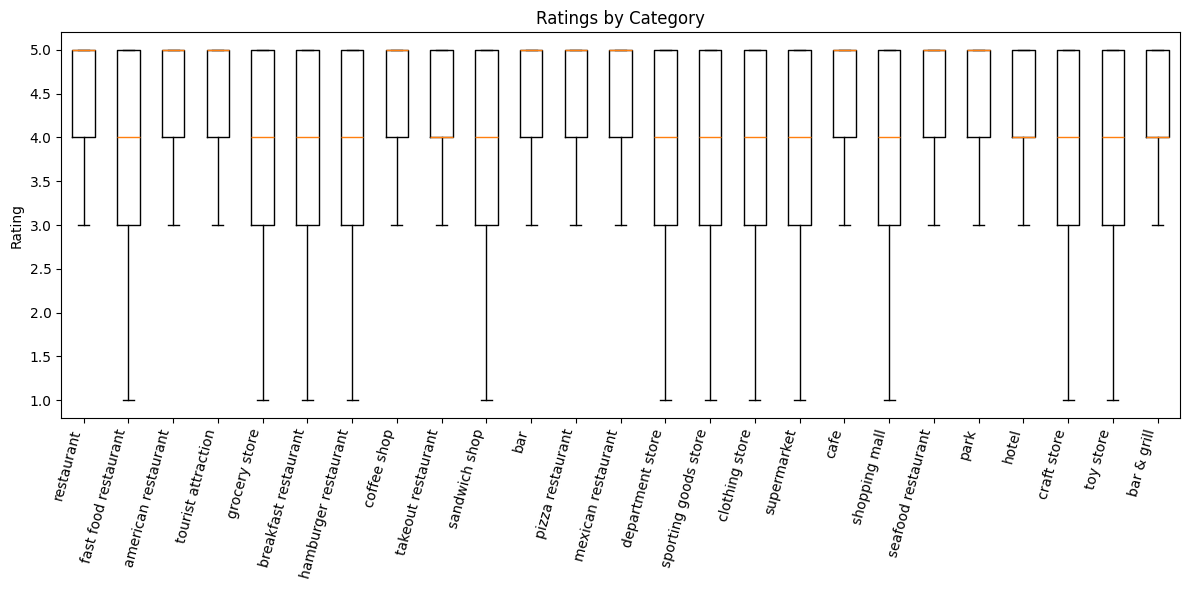

In [31]:
df_rating = join_df_pandas.copy()

# Keep only required column
cols = ["rating", "category_list", "text", "review_time"]
df_rating = df_rating[cols]

# Turn category_list into one row per category
df_after_explode = explode_categories(df_rating)

# Aggregate per category
cat_agg = (df_after_explode.groupby("category", as_index=False)
              .agg(n_reviews=("rating", "size"), avg_rating=("rating","mean"), p25=("rating", lambda s: s.quantile(0.25)), p75=("rating", lambda s: s.quantile(0.75))))

# Choose categories with high number of reviews
min_reviews = 200
top_by_count = (cat_agg[cat_agg["n_reviews"]  >= min_reviews].sort_values("n_reviews", ascending=False).head(25))

# Boxplot for top categories by review volume
cats = top_by_count["category"].tolist()
plot_data = [df_after_explode.loc[df_after_explode["category"] == c, "rating"].values for c in cats]

plt.figure(figsize=(12,6))
plt.boxplot(plot_data, showfliers=False)
plt.xticks(ticks=np.arange(1, len(cats)+1), labels=cats, rotation=75, ha="right")
plt.ylabel("Rating")
plt.title("Ratings by Category")
plt.tight_layout()
plt.show()

The boxplot contains the distribution of ratings for the 25 most-reviewed categories, which have at least 200 reviews each. According to the boxplot, categories with a high number of reviews (at least 200 reviews) tend to have high median values, ranging from 4 to 5 stars. Most of the categories are right-skewed. The key differences among high-volume categories are in variability, not in the central tendency. There are restaurants that do not have any low ratings, such as American restaurants or pizza restaurants, while there are others still facing low ratings, such as fast food restaurants or hamburger restaurants. However, looking at the retail stores, such as grocery stores or sporting goods stores, they all have low ratings. This indicates that while eating places with a high number of reviews have a mix of restaurants with and without low ratings, retail stores tend to always have at least one low rating in their reviews. Apart from these two types, other types, such as accommodation places or public places, do not have enough data to compare.

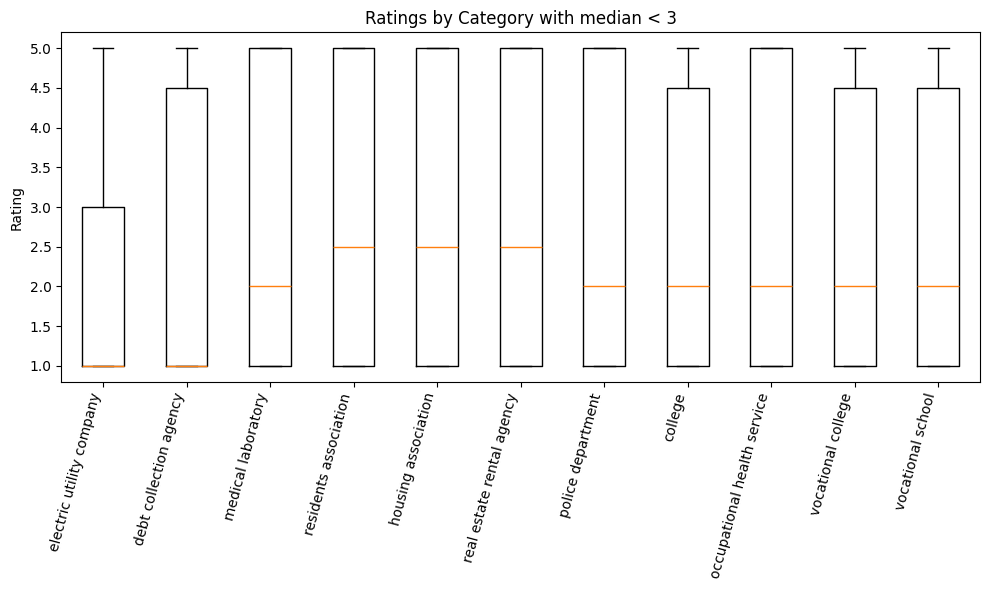

In [32]:
# Aggregate per category
cat_median = (
    df_after_explode.groupby("category")["rating"]
      .agg(n_reviews="size", median="median")
      .reset_index()
)

# Keep only categories which have median rating lower than 3
low_cat = cat_median[cat_median["median"] < 3].sort_values("n_reviews", ascending=False)

if low_cat.empty:
# Check whether the dataset with low-rating categories is empty.
    print("No categories have median rating < 3.")
else:
# Otherwise, plot boxplot for low-rating categories
    cats = low_cat["category"].tolist()
    # Make sure the ratings of each category in the same order as `cats`
    plot_data = [df_after_explode.loc[df_after_explode["category"].eq(c), "rating"].values for c in cats]


    width = builtins.max(10.0, builtins.min(28.0, 0.35 * len(cats)))
    plt.figure(figsize=(width, 6))
    plt.boxplot(plot_data, showfliers=False)
    plt.xticks(ticks=np.arange(1, len(cats) + 1), labels=cats, rotation=75, ha="right")
    plt.ylabel("Rating")
    plt.title("Ratings by Category with median < 3")
    plt.tight_layout()
    plt.show()

The boxplot contains rating distributions for only those categories that have median ratings lower than 3. According to the box plot of low-rating categories, it is demonstrated that categories that are compulsory, administrative, or enforcement-related tend to have lower median ratings and higher variability. For instance, both the electric utility company and debt collection agency have a median value of 1 and very high variability. Because these categories are compulsory or enforcement-related, they tend to be used by a huge number of people. This could lead to long waits and delays in the process, making people tend to complain more.

In [33]:
# Show full review text without truncation when displaying DataFrames
pd.set_option("display.max_colwidth", None)

# Make dataframe cells wrap multi-line
display(HTML("""
<style>
.dataframe td, .dataframe th { white-space: normal !important; }
</style>
"""))

# Ensure NLTK data is imported. Otherwise, download the data
def ensure_nltk_data():
    needed = [("stopwords","corpora/stopwords"),
              ("vader_lexicon","sentiment/vader_lexicon"),
              ("punkt","tokenizers/punkt")]
    for pkg, handle in needed:
        try:
          nltk.data.find(handle)
        except LookupError:
          nltk.download(pkg)
ensure_nltk_data()

# Instantiate necessary variables
low_rating_max = 2.5        # Choose ratings <= 2.5 as low ratings
top_terms  = 10             # Show top 10 negative words
review_per_term = 3         # Show how many text reviews per negative term
show_snippets = False       # Set to False to show untruncated text snippets
snippet_chars = 140         # Length of text snippet if show_snippets is set to True

# Work on a copy dataframe to avoid mutating the original dataframe
df = join_df_pandas.copy()
# Keep only low ratings rows
low_rating_df = df[df["rating"] <= low_rating_max].copy()

# Use the generic stopwords from NTLK
base_stops = set(nltk_stopwords.words("english"))
# Add a custom set of the stopwords to dedal with contractions typed without apostrophes, filler, and domain-generic nouns
custom_stops = {
    "im","ive","dont","didnt","doesnt","cant","couldnt","wouldnt","shouldnt",
    "u","ur","us","wa","wo","nt","amp","lol","ok",
    "place","restaurant","food","shop","store","mall","hotel"
}
# Combine base and custom stopwords to create a final stopword set
stopwordsSet = base_stops | custom_stops
# Load Vader
vader = SentimentIntensityAnalyzer()
# Keep Vader words which sentiment score is negative
NEG_LEX = {w for w, score in vader.lexicon.items() if score < 0}

def tokenise_clean(review: str):
    """
    The functions turn a review into a clean list of words.
    A clean word means it was converted to lowercase.
    A clean word can contain letters and apostrophes.
    A clean word is not a stopword and has at least 3 characters.
    The function returns a list of clean words.
    """
    tokens = re.findall(r"[a-z']+", str(review).lower())
    return [token for token in tokens if len(token) >= 3 and token not in stopwordsSet]

def to_list(cats):
    """
    The function converts various possible formats of category_list into a Python list.
    """
    if isinstance(cats, (list, tuple, set)):
    # If v is already list-like, copy or convert it into a Python list
      vals = list(cats)
    else:
    # Otherwise, v will be treated as a string.
      cat = "" if pd.isna(cats) else str(cats).strip() # Check if the cell is NA, fill it with "", else else convert it to string and trim outer whitespace
      # Check whether s looks like a Python list literal
      if cat.startswith("[") and cat.endswith("]"):
        # If s starts with [ and ends with ],  evaluate for Python literals
        parsed = ast.literal_eval(cat)
        # If the result is list-like, copy or convert it into a Python list
        if isinstance(parsed, (list, tuple, set)):
          vals = list(parsed)
        else:
        # Otherwise, split the result based on common delimiters into a Python list
          vals = re.split(r"[,/;|]", cat)
      else:
      # Otherwise, split the result based on common delimiters into a Python list
        vals = re.split(r"[,/;|]", cat)

    # Instantiate an empty list that will hold cleaned category strings
    cleaned = []
    # Loop through every value in vals
    for val in vals:
      if val is None:
      # Skip None entries
        continue
      # Convert the value into a string, trim outer whitespace, and convert it to lowercase
      clean = str(val).strip().lower()
      if clean:
      # If the value is not an empty string after cleaning, add it to the cleaned list
        cleaned.append(clean)
    # Reemove any duplicates without changing order, then convert back to list
    return list(dict.fromkeys(cleaned))

low_rating_df["category_list"] = low_rating_df["category_list"].apply(to_list)
low_rating_df["tokens"] = low_rating_df["text"].apply(tokenise_clean)

# Extract top negative words from the Dataframe
neg_tokens = [token for tokens in low_rating_df["tokens"] for token in tokens if token in NEG_LEX]
neg_df = (
    pd.DataFrame(Counter(neg_tokens).most_common(top_terms), columns=["term","count"])
)
print("Top negative words in low-rating reviews:")
display(neg_df)

def example_reviews_for_term(term, num = review_per_term):
  """
  The function takes a negative words and returns a table of num or number of low ratings,
  complaints and their category list of reviews that contain that negative word.
  """
  pattern = rf"\b{re.escape(term)}\b"
  low_rating = low_rating_df[low_rating_df["text"].str.contains(pattern, case=False, na=False)].copy()
  low_rating = low_rating.drop_duplicates(subset=["text"])
  if show_snippets:
      low_rating["text"] = (low_rating["text"]
                      .str.replace(r"\s+", " ", regex=True)
                      .str.slice(0, snippet_chars) + "…")
  # Return a table of low ratings with reviews and its category list
  return low_rating[["rating", "text", "category_list"]].head(num)

for term in neg_df["term"]:
    print(f"\n=== TERM: {term} ===")
    display(example_reviews_for_term(term))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Top negative words in low-rating reviews:


term  count
0           bad   1650
1          rude   1495
2      horrible    953
3         worst    903
4      terrible    898
5          poor    877
6         wrong    850
7           pay    792
8         dirty    643
9  disappointed    568


=== TERM: bad ===


rating  \
75         1   
233        1   
1251       1   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        text  \
75                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              WOW... Did this company really just release someone's personal number...? That seems very unprofessional. Let me get this straight. You got a bad review, and lashed out with someone's personal info? Say there, what's your number? I'd like to share it with.... NO ONE! Because that doesn't seem right.   
233   So long story but they're scammers for people in the military! I went in to have an exam and fillings done and the total came out to 400$! I thought that was completely wrong!! So I called my insurance and turns out I was right! I should've only been paying 50$ for the all the fillings and when I called BTY to confront them all they said is they haven't received their money from my insurance and that I still needed to pay and would not get reimbursed I literally went the other day insurance takes a bit to take over...and they wanted their money up front with running it through my insurance, they also said I needed 2 crown and I got a second opinion because I'm only 19! And I've never had a problem with my teeth so I went to another dentist to look and he said nothing was wrong with my teeth and I probably didn't need the fillings to begin with and they did such a bad job on the fillings too to the point my gums and teeth hurt so bad I can't stop crying   
1251                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               Pretty unhelpful, smug and sarcastic inside help. Must hate thier job.\nAlthough I did buy two Honda generators 4 years prior at a premium price. My second attempt at buying another generator was completely sqaushed by the lack of motivation, laziness and bad attitude.\nSo I went to Lowe's and got great service.   

                                    


=== TERM: rude ===


rating  \
80         1   
256        1   
1506       1   

                                                                                                                                                                                                                                                                                                                                                                                                                                   text  \
80    Very rude people. I had to call back and ask for a taxi that would fit 4 adult and a kid, the man who answered rudely said you know what we can’t keep sending taxis out to you just call someone else. No one even came out and showed up. So how would it hurt to send someone with a bigger car. Very disrespectful. Don’t take this cab company just can yellow cab their much nicer. If I could rate this zero stars I would   
256                                                                                                                                                                                                                                                                                                                                                                                  Poor service! Employee was rude and uninformative.   
1506                                                                                                                                                                          9/08/2016\n\nThe native woman behind the counter was rude, annoying, and never said "hello", never greeted me or ever once smiled. Never once let me know what she was doing, to keep me informed. Is this the kind of service we can expect from UPS????   

                                                                                                                                                                                       category_list  
80                                                                                                                                                                                    [taxi service]  
256                                                                                                                                [shipping and mailing service, mailing service, shipping service]  
1506  [shipping and mailing service, business center, freight forwarding service, mailbox rental service, notary public, office supply store, packaging supply store, print shop, shredding service]


=== TERM: horrible ===


rating  \
1518       1   
2621       1   
3578       1   

                                                                                                                                                                                                                                           text  \
1518                                                                      Horrible slowest branch ever new girl doesn't even know how to send a wire transfer something that takes 5 minutes took her 30 minutes worst customer service ever!!!   
2621  Horrible customer service, can never reach someone to talk to to address their own mistakes. Their own customer service phone numbers are worthless and it requires hours of digging, waiting, and multiple phone calls to reach someone.   
3578                                                                                                                      horrible experience, lost my order was treated like crap when I asked about my food. Taking my pizza orders elsewhere   

                                                                category_list  
1518                  [credit union, atm, financial institution, loan agency]  
2621                                                       [insurance agency]  
3578  [pizza restaurant, delivery restaurant, takeout restaurant, restaurant]


=== TERM: worst ===


rating  \
81         1   
1512       1   
1515       1   

                                                                                                                                                                                                                                text  \
81                                                                                                                                                                             Worst service ever. Save your time, use Ubee or Lfty.   
1512                                                                                                                        Always long lines and nobody working. The worst bank you can have. They are slow, lazy and understaffed.   
1515  This is litterally the worst credit union in town staff make up fake policies because they are too lazy to want to do their job every time we go here we have a problem then we go to a different and lookie there no problems   

                                                category_list  
81                                             [taxi service]  
1512  [credit union, atm, financial institution, loan agency]  
1515  [credit union, atm, financial institution, loan agency]


=== TERM: terrible ===


rating  \
254        2   
1682       1   
1853       1   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      text  \
254   WHY ARE YOU ONLY OPEN A COUPLE HOURS? The only reason you have two stars is because you have recently put out two drop-boxes instead of just the one. Unfortunately, the only time I ship with UPS is to return my college books which I send in a box that does not fit your drop box slot. Most of the time, the drop boxes are full to the brim and people could easily have their things stolen. Please get a larger drop box.\n\nI have nothing to say about the service considering I have never actually encountered anyone at UPS due to the terrible hours.   
1682                                                                                                                                                                                                                                                                                                              Terrible at communicating. I called multiple times to check the status of a part they "ordered". Come to find they had never ordered the part. Charged me hundreds of dollars and were not able to figure out the problem. Had to call another mechanic.   
1853                                                                                                                                                                                                                                                                                                                                                                                                     Terrible customer service!!!!!! Always giving people the run around\n\nThey also hung up on me as well!!!!\n\nI am very surprised they are still in business\n\nI   

                                                                                          category_list  
254                                   [shipping and mailing service, mailing service, shipping service]  
1682  [heating contractor, air duct cleaning service, furnace repair service, hvac contractor, plumber]  
1853                                                                          [truck accessories store]


=== TERM: poor ===


rating  \
256       1   
430       1   
439       2   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       text  \
256                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      Poor service! Employee was rude and uninformative.   
430  DO NOT GO HERE.\n\nI used Stevens Gla


=== TERM: wrong ===


rating  \
233        1   
1395       1   
1513       1   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        text  \
233   So long story but they're scammers for people in the military! I went in to have an exam and fillings done and the total came out to 400$! I thought that was completely wrong!! So I called my insurance and turns out I was right! I should've only been paying 50$ for the all the fillings and when I called BTY to confront them all they said is they haven't received their money from my insurance and that I still needed to pay and would not get reimbursed I literally went the other day insurance takes a bit to take over...and they wanted their money up front with running it through my insurance, they also said I needed 2 crown and I got a second opinion because I'm only 19! And I've never had a problem with my teeth so I went to another dentist to look and he said nothing was wrong with my teeth and I probably didn't need the fillings to begin with and they did such a bad job on the fillings too to the point my gums and teeth hurt so bad I can't stop crying   
1395                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      They knocked down some historic bars to put up this monstrosity. The city was wrong anyway- tearing them down didn't reduce crime in town one bit.   
1513                                                                                                         Every time i ask what my balance is over the phone, the people here ALWAYS tell me the wrong number.\n\nI was approved for a $600 loan twice. No prob. Both paid on time every time One day I was trying for same thing right after TRUMP won election & i said I voted for him. Not approved for same amount or lower since. Wow. I mean, i saw the excitement leave the person's face as they shook a little like a transformation. Then rudeness after. Kind of a spectacle now that I think about it. LOL. Werewolf tellers that change when hearing Pro-Trump talk. Scared me a little though. I didn't wanna get bite & infected like a zombie or become one of them. I enjoy my freedom. That's why I live in Alaska. I Just need a better more modern bank I guess.\n\nStay away from this bank. Werewolves zombies work here. Hate to see what would of happened if I wore a MAGA hat.   

                                    


=== TERM: pay ===


rating  \
233        1   
1317       1   
1847       1   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           text  \
233                                                                                                      So long story but they're scammers for people in the military! I went in to have an exam and fillings done and the total came out to 400$! I thought that was completely wrong!! So I called my insurance and turns out I was right! I should've only been paying 50$ for the all the fillings and when I called BTY to confront them all they said is they haven't received their money from my insurance and that I still needed to pay and would not get reimbursed I literally went the other day insurance takes a bit to take over...and they wanted their money up front with running it through my insurance, they also said I needed 2 crown and I got a second opinion because I'm only 19! And I've never had a problem with my teeth so I went to another dentist to look and he said nothing was wrong with my teeth and I probably didn't need the fillings to begin with and they did such a bad job on the fillings too to the point my gums and teeth hurt so bad I can't stop crying   
1317                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                No auto pay   
1847  Awesome customer service over the phone. Unfortunately that's where it ends.\n\n- I had to pay over the phone in full ($605) for an appointment on their books.\n- Appointment was made for autostart install, tire switchover, and alignment.\n- I showed up for my 9am Tuesday drop-off appointment and was told they moved my appointment to Thursday. They stated they had the wrong phone number for me which is why I didn't know.\n- They said they'd do the tire switchover and alignment but couldn't do the remote start unless I wanted to switch appointment days. I chose to forgo the autostart and just get the tires switched and alignment.\n- I called Extreme Auto at 5:45pm because I had yet to hear back from th


=== TERM: dirty ===


rating  \
1947       1   
4015       2   
4529       1   

                                                                                                                                                                                                                                                                                                                                                                                                                              text  \
1947  As Emerald Executive Elite members, it was my worst experience! Besides I got a dirty vehicle, I wasn't allowed to change vehicle because they "locked the keys" an hour before closing. They won't pre-arrange to change vehicle because I have to call first the next morning. I'm already in front of the counter and they can't do that for me. Terrible and worst rental service I have ever experienced with National.   
4015                                                                                                                                                                                                                   I had a consult here. Did not like the look of the place. Very shabby and under construction or empty and dirty. Didn't look professional. Really nice guy, and his portfolio looks like he does good work.   
4529                                                                                             I have been a member here for years. And in the last couple years this place has gone way WAY down hill. It's always dirty and the equipment is not kept up very well anymore. It's like they just dont care anymore. Kinda sad really it used to be a good alternative to the over priced other place out here. Now not so much.   

                                             category_list  
1947                                   [car rental agency]  
4015                                         [tattoo shop]  
4529  [physical fitness program, gym, weight loss service]


=== TERM: disappointed ===


rating  \
1191       1   
1617       1   
2613       1   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   text  \
1191   I called them for a conex van and the woman quoted me for a price. I asked her if they delivered and she said yes it included delivery. Then..... I went over to purchase the conex and she told me that there was a 250.00 per hour delivery charge!! And. She told me she could not deliver it for a week. The employee that showed me the conex asked me if I wanted it today or tomorrow.\nSo, it was very confusing and I was treated like a red headed stepchild!!\nLooks like I will not be going back there anymore.\nNo one was wearing masks and everyone was on their cellphones.\nVery disappointed.   
1617  The customer service rep I dealt with was rude and short with me. Obviously I didn’t call her because I was having a great day- my car was broken down- she couldn’t sound like she wanted to talk to me less than what she did. She was rude and snooty. Sorry your job is so hard that it requires helping people- sometimes people who can’t afford to fix their cars but are broken down alongside the road. Even if it’s fake, some SOME customer service would have been better than what she provided.  Very disappointed. But the prices were what I could afford- so what else can you do but use them ?   
2613                                                                                                                                                                                                                                                                                            This library's free WiFi fails to provide decent service and speed, unacceptable.  I go there and am more times disappointed than not attempting to use their dismal internet.  I get a connection, with an agonizingly slow connection, terminating my session and leaving, unable to update my apps on my smartphone.   

                                                                                                                                                                                                  category_list  
1191                                                                                                                                                   [mover, moving and storage service, moving supply store]  
1617  [self-storage facility, moving and storage service, moving supply store, packaging supply store, trailer rental service, trailer supply store, truck rental agency, used truck dealer, van rental agency]  
2613                                                                                                                                                                                           [public library]

The strategy is to take a dataset and extract only rows that have low ratings, or in this case, any rating that is lower than 3. The text column, which contains reviews, will be tokenised. Any stop words (both from the nltk.corpus package and from the custom stop words set) will be removed from each text cell, and the text cell will keep only words that are present in VADER's negative lexicon. The strategy is to extract the top negative words among all the bad reviews and low ratings. For each top negative word, a few low-rating reviews that contain that negative word, along with their categories, will be printed out. This allows the user to see the whole complaints of the low ratings and top negative words.

According to the result of the code, the top 10 negative words are bad, rude, horrible, worst, terrible, poor, wrong, pay, dirty, and disappointed. Looking at the full complaints based on these negative words, it appears that poor customer service and unprofessional staff tend to lead to many bad reviews, as many customers have used rude, horrible, worst, terrible, poor, dirty and disappointed when they wrote a complaint. Moreover, safety concerns also make up for many low ratings since many people are concerned about scam problems and privacy breaches. This can be seen with the keyword "bad" as all three of the reviews that have "bad" in them are talking about the person being scammed or their personal information has been breached and leaked to another third party. Other problems that cause low ratings are businesses that close too early, or their technologies are not up-to-date, or historic places being knocked down for other businesses. Some categories most often having low ratings are taxi service, shipping and mailing, credit unions, and dental clinics.


### Focus on the reviewer level withall the reviewed business history:
- Check on the reviewer level reviewed business, sort the review of each business by the review time (newtime column) and then save the business name into the list variable user_business_list for each reviewer.
- Could you observe some repeated business names for the same user?
- Could you find the user similarities according to their past reviewed business ?

To address the task, we focused on reviewer-level business histories by first sorting each reviewer’s records by business name and review time, thereby ensuring a chronological ordering of visits. The results were aggregated into a user_business_list, which records the full sequence of businesses reviewed by each individual. This step produced a structured view of reviewer behaviour that forms the basis for deeper exploration of reviewing habits.

In [34]:
# data from the reviewers point of view
reviewer_reviewed_business = join_df_pandas[['user_id','reviewer_name','business_name','newtime']]
# Sort reviews of each business by the review time
reviewer_reviewed_business = reviewer_reviewed_business.sort_values(
    by=['business_name', 'newtime'],
    ascending=[True, True]   # business alphabetical, then time ascending
).reset_index(drop=True)

display(reviewer_reviewed_business.head(10))


user_id              reviewer_name              business_name  \
0  1.047092e+20                     Josh Q  1-800-GOT-JUNK? Anchorage   
1  1.109116e+20          Kristin Carpenter  1-800-GOT-JUNK? Anchorage   
2  1.158814e+20               Marcos Isaac  1-800-GOT-JUNK? Anchorage   
3  1.054774e+20                missy nurmi  1-800-GOT-JUNK? Anchorage   
4  1.133753e+20             shadie Solomon  1-800-GOT-JUNK? Anchorage   
5  1.020192e+20             Vercara Foster  1-800-GOT-JUNK? Anchorage   
6  1.070340e+20               Heather Long  1-800-GOT-JUNK? Anchorage   
7  1.040937e+20            Dillon Chappell  1-800-GOT-JUNK? Anchorage   
8  1.159131e+20                Google User  1-800-GOT-JUNK? Anchorage   
9  1.156619e+20  Pete Donahoo (PJ, PeteyD)  1-800-GOT-JUNK? Anchorage   

      newtime  
0  2019-02-26  
1  2019-04-11  
2  2019-05-08  
3  2019-12-21  
4  2020-02-07  
5  2020-02-28  
6  2020-08-27  
7  2020-08-29  
8  2020-10-06  
9  2020-10-19

In [35]:
# collect businesses per reviewer
user_business_list = reviewer_reviewed_business.groupby(['user_id','reviewer_name'])['business_name'].agg(list).reset_index()
user_business_list  = user_business_list.rename(columns={'business_name': 'user_business_list'})


In [36]:
n = 10

print(f"Duplicate businesses for the first {n} users:")

for index, row in user_business_list.head(n).iterrows():
   #find duplicate business names in the list
    reviewer_name = row['reviewer_name']
    user_business_list = row['user_business_list']

    # if the business name is already in the list, add it to the duplicates list
    seen = set()
    duplicates = [x for x in user_business_list if x in seen or seen.add(x)]

    if duplicates:
        print(f"\nReviewer: {reviewer_name}")
        print(f"Duplicate businesses: {list(set(duplicates))}")
    else:
        print(f"\nReviewer: {reviewer_name}")
        print("No duplicate businesses found.")

Duplicate businesses for the first 10 users:

Reviewer: orlando taporco
Duplicate businesses: ["McDonald's", 'Anchorage 5th Avenue Mall']

Reviewer: Erica Hill
Duplicate businesses: ["Simon & Seafort's Saloon & Grill"]

Reviewer: M Ric
No duplicate businesses found.

Reviewer: Francis B
Duplicate businesses: ['Taco Bell', 'China Lights Oriental Cuisine']

Reviewer: C•lt•n G.
Duplicate businesses: ['Sonic Drive-In']

Reviewer: C•lt•n G. (KodakColt)
No duplicate businesses found.

Reviewer: James Oakley
No duplicate businesses found.

Reviewer: P Ursery
No duplicate businesses found.

Reviewer: Jonathan bunt
No duplicate businesses found.

Reviewer: Victoria Inthaly
Duplicate businesses: ['Fred Meyer']


In the second stage, we examined each reviewer’s business list for duplicates, as many users had submitted multiple reviews for the same business. To prevent over-representation, duplicates were removed while maintaining the order of visits. For instance, orlando taporco’s list decreased from 23 to 21 businesses, Francis B from 48 to 46, and joseph ward from 41 to 38. In contrast, other users such as M Ric showed no change, as they had reviewed only unique businesses. This step was essential to ensure that reviewers’ profiles reflected breadth of engagement rather than frequency of revisits.

In [37]:
# Recreate user_business_list as a DataFrame to ensure it's not a list
user_business_list = reviewer_reviewed_business.groupby(['user_id','reviewer_name'])['business_name'].agg(list).reset_index()
user_business_list  = user_business_list.rename(columns={'business_name': 'user_business_list'})

# Print the number of businesses reviewed by each user before removing duplicates
print("Number of businesses reviewed by each user before removing duplicates:")
display(user_business_list.apply(lambda row: (row['reviewer_name'], len(row['user_business_list'])), axis=1).to_frame(name='reviews_count').head(20))

# remove duplicates from the list by using dict.fromkeys
user_business_list['user_business_list'] = user_business_list['user_business_list'].apply(lambda x: list(dict.fromkeys(x)))

# Print the number of businesses reviewed by each user after removing duplicates
print("Number of businesses reviewed by each user after removing duplicates:")
display(user_business_list.apply(lambda row: (row['reviewer_name'], len(row['user_business_list'])), axis=1).to_frame(name='reviews_count').head(20))


Number of businesses reviewed by each user before removing duplicates:


reviews_count
0         (orlando taporco, 23)
1              (Erica Hill, 17)
2                   (M Ric, 10)
3               (Francis B, 48)
4               (C•lt•n G., 11)
5   (C•lt•n G. (KodakColt), 10)
6            (James Oakley, 17)
7                (P Ursery, 10)
8           (Jonathan bunt, 19)
9        (Victoria Inthaly, 15)
10        (Amanda Franklin, 21)
11           (Trent Rogers, 22)
12            (joseph ward, 41)
13        (Jessica Krieger, 12)
14      (Stefenie Mccallie, 10)
15       (Genita Thirlwell, 35)
16         (W David Schaad, 10)
17                 (Bill J, 11)
18            (Mike Nelson, 12)
19                (Chris R, 13)

Number of businesses reviewed by each user after removing duplicates:


reviews_count
0         (orlando taporco, 21)
1              (Erica Hill, 16)
2                   (M Ric, 10)
3               (Francis B, 46)
4               (C•lt•n G., 10)
5   (C•lt•n G. (KodakColt), 10)
6            (James Oakley, 17)
7                (P Ursery, 10)
8           (Jonathan bunt, 19)
9        (Victoria Inthaly, 14)
10        (Amanda Franklin, 20)
11           (Trent Rogers, 22)
12            (joseph ward, 38)
13        (Jessica Krieger, 12)
14      (Stefenie Mccallie, 10)
15       (Genita Thirlwell, 35)
16         (W David Schaad, 10)
17                 (Bill J, 11)
18            (Mike Nelson, 12)
19                (Chris R, 13)

Finally, we explored user similarities based on their reviewed businesses. The cleaned user_business_list was first “exploded” into individual rows, producing one entry per reviewer–business pair. Using pd.crosstab, we constructed a sparse user–business matrix in which rows represented reviewers, columns represented businesses, and values indicated whether a reviewer had engaged with a given business. The similarity matrix is built by first encoding the data into a user–business matrix, where each row represents a reviewer and each column represents a business (1 if reviewed, 0 otherwise).

We then applied cosine similarity, a common measure in recommender systems, to compare reviewers’ business histories. The resulting similarity matrix showed that most pairs of reviewers had very low overlap, with similarity values close to zero. However, some clusters exhibited moderate overlap, such as orlando taporco and Bernard Wheeler (≈0.39). To visualise patterns more effectively, we sampled ten random users and generated a heatmap. The heatmap was largely sparse, highlighting the diversity of reviewer behaviour, but occasional pockets of higher similarity indicated groups with shared preferences.

Top similar users to orlando taporco:
reviewer_name
orlando taporco           1.000000
Bernard Wheeler           0.385758
Sika Moua                 0.328976
Mark Han                  0.318511
Tracy Taylor              0.318511
Raghupavan Vallamkonda    0.314970
TUCKER CUNNINGTON         0.308607
Leanne Morrison           0.308607
Terina Saari              0.308607
Adeline Leung             0.306719
Name: orlando taporco, dtype: float64


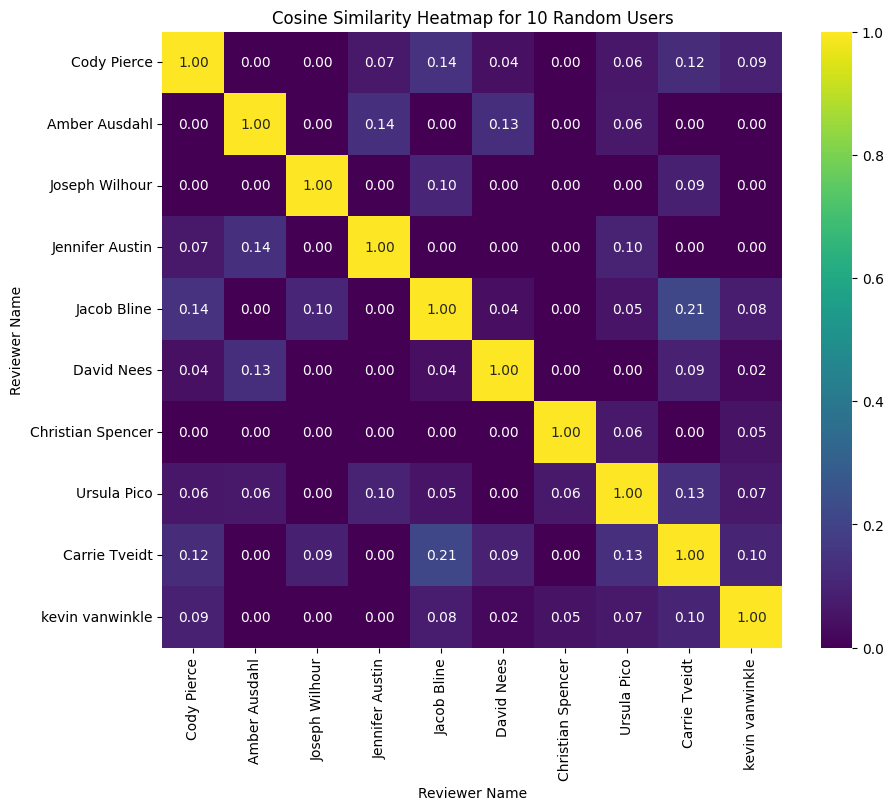

In [38]:
# One-hot encode business names for each user
# Explode the list into rows
exploded = user_business_list.explode('user_business_list')

# Create a user-business matrix
user_business_matrix = pd.crosstab(exploded['reviewer_name'], exploded['user_business_list'])

# Compute cosine similarity between users
similarity_matrix = pd.DataFrame(
    cosine_similarity(user_business_matrix),
    index=user_business_matrix.index,
    columns=user_business_matrix.index
)

# Inspect similarities for a few users
# Example: top 5 most similar users to "orlando taporco"
target_user = "orlando taporco"
similar_users = similarity_matrix[target_user].sort_values(ascending=False).head(10)

print(f"Top similar users to {target_user}:")
print(similar_users)


# Sample random users
random.seed(42)
sample_users = random.sample(list(similarity_matrix.index), 10)

# Extract the similarity matrix for the sampled users
sample_similarity_matrix = similarity_matrix.loc[sample_users, sample_users]

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(sample_similarity_matrix, annot=True, cmap='viridis', fmt=".2f")
plt.title('Cosine Similarity Heatmap for 10 Random Users')
plt.xlabel('Reviewer Name')
plt.ylabel('Reviewer Name')
plt.show()


The results show that most reviewers visit very different businesses, but there are still small groups of users with overlapping patterns. In the heatmap, this appears as faint, mostly sparse areas with a few darker patches where similarities are stronger. These darker clusters suggest small neighbourhoods of users who tend to review similar sets of businesses, which could be useful for identifying groups of like-minded reviewers, recommending new businesses, or flagging unusual behaviour. At the same time, some limitations must be considered. Large chains recorded under a single name can exaggerate similarity, and our method only captures whether a reviewer has visited a business, without considering frequency, recency, or sentiment. Future improvements could address these issues through weighted measures or advanced models such as PCA or matrix factorisation. Even so, cosine similarity with a heatmap provides a simple, efficient, and visually interpretable way to compare reviewer behaviour.

# Prediction

In [39]:
review_patterns

user_id      reviewer_name           time  rating  \
0       1.091298e+20         Nicki Gore  1566331951619       5   
1       1.132409e+20      Allen Ratliff  1504917982385       5   
2       1.130448e+20  Jonathan Tringali  1474765901185       4   
3       1.103292e+20             S Blad  1472858535682       4   
4       1.089896e+20     Daniel Formoso  1529649811341       5   
...              ...                ...            ...     ...   
521510  1.063779e+20      Emily Stanker  1595464050942       3   
521511  1.182198e+20          Jeri Hill  1573608171589       3   
521512  1.170553e+20     Stas Moszynski  1520481904459       3   
521513  1.130331e+20        Kalli Kline  1612036301339       4   
521514  1.091719e+20   Ed ThePopPunkKid  1571068334950       5   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            text  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                We always stay here when in Valdez for silver salmon fishing. The elderly couple that run it are amazing to talk to, extremely helpful. The campsites are very well maintained.   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         Great campground for the price. Nice hot unlimited showers, laundy, and  spacious wooded lots. Full hook ups. Late check in available.   
2       We tent camped here for 2 nights while exploring Valdez. The center of the campground was in the open and there are treed sites around the edges. Don't expect lower foliage separating the sites. Still this is much nicer than the other RV parking lots in town which seemed wide open.\n\nThere is a bath house with 1 set of coin operated washer/dryer, 2 restrooms (sink toilet) and 2 shower rooms (sink, toilet, shower). The hot water will run out after a few showers. They provide floor mats towels for you to use which is nice, but they lack vent fans to remove moisture so it is prone to mold.\n\nWi-Fi didn't reach our site on the back edge of the campground. Overall we were happy with our stay at this campground and would stay there again.   
3                                                                                                                                                                                                   

### Explore the review time series

Mean daily reviews used to fill missing days: 163.635
Span: 2007-10-13 → 2021-09-08 (5080 days)


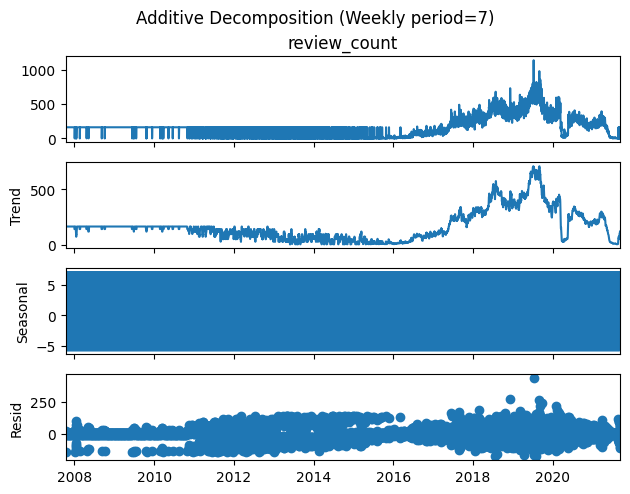

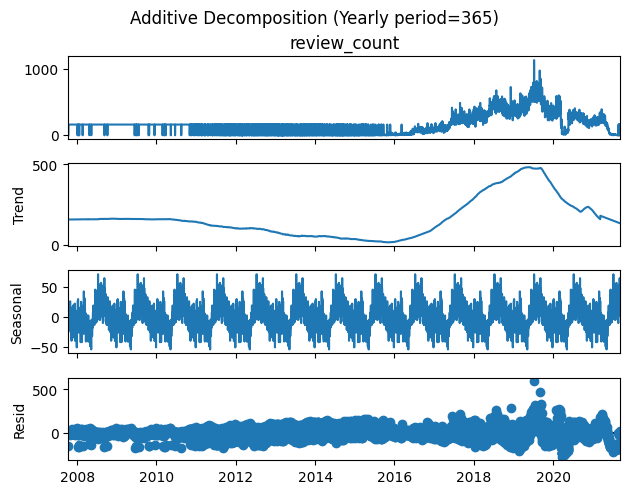

In [40]:
df2 = join_df_pandas.copy()
df2['newtime'] = pd.to_datetime(df2['newtime'], errors='coerce')

#Group by calendar day (not full timestamp)
daily = (df2.assign(day=df2['newtime'].dt.floor('D')).groupby('day').size().rename('review_count').sort_index())

#Add missing days and fill with global mean daily reviews
full_days = pd.date_range(daily.index.min(), daily.index.max(), freq='D')
mean_daily = daily.mean()
daily_filled = (
    daily.reindex(full_days)
         .fillna(mean_daily)
)
daily_filled.index.name = 'day'
print(f"Mean daily reviews used to fill missing days: {mean_daily:.3f}")
print(f"Span: {daily_filled.index.min().date()} → {daily_filled.index.max().date()} "f"({len(daily_filled)} days)")

#Additive seasonal decomposition
period = 7
use_yearly = (len(daily_filled) >= 730)
figs = []

#Weekly seasonality
decomp_week = seasonal_decompose(daily_filled, model='additive', period=period, extrapolate_trend='freq')
fig1 = decomp_week.plot()
fig1.suptitle('Additive Decomposition (Weekly period=7)', y=1.02)
figs.append(fig1)

#Yearly seasonality
if use_yearly:
    decomp_year = seasonal_decompose(daily_filled, model='additive', period=365, extrapolate_trend='freq')
    fig2 = decomp_year.plot()
    fig2.suptitle('Additive Decomposition (Yearly period=365)', y=1.02)
    figs.append(fig2)

plt.show()

trend_change = (daily_filled.rolling(30, min_periods=1).mean().iloc[-1] -
                daily_filled.rolling(30, min_periods=1).mean().iloc[0])


I aggregated reviews by newtime into a daily series, inserted any missing calendar days, and filled those gaps with the global mean daily count as instructed. I then applied seasonal_decompose(model='additive') and interpreted the components: the seasonal term captures the weekly cycle (with clear workday vs. weekend structure), the trend reflects longer-term movement in activity, and the residuals show remaining noise. This pipeline matches the task’s exact steps (construct series, fill with mean, additive decomposition) and presents findings that are consistent with a weekly seasonal signal, if variance were level-dependent, a multiplicative model could be compared as a sensitivity check.

### Use time series model ARIMA for forecasting the future

In [41]:
# Convert the time series to a NumPy array of float64
X = daily_filled.values.astype("float64")
# Split the train and test set with the proportion of 80% - 20%, respectively
split = int(len(X)*0.8)
train,test = X[:split], X[split:]

# Build all 27 combinations for p, d, q to try
orders = list(itertools.product([0,1,2],[0,1,2],[0,1,2]))

def measure_mae(order):
    """
    The function take an order for p,d,q to try.
    Fit an ARIMA model on the train set, then produce predictions using the test set.
    Returns mean absolute error (MAE) of the predictions, and predicted values array.
    """
    # Instantiate the p,d,q to the list of 27 combinations
    p,d,q = order
    # Ignore all Convergence or Invertibility warnings during the gird search
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        # Build an Arima model on the train set.
        mod = ARIMA(train,
                    order=order,
                    trend=('n' if d>0 else 'c'),  # drop intercept if differenced to avoid redundancy
                    enforce_stationarity=False,   # allow non-stationary params if needed
                    enforce_invertibility=False)  # allow non-invertible params if needed

        try:
          # Try to fit the Arima model while passing optimiser options via method_kwargs
          fitted_mod = mod.fit(method_kwargs={"warn_convergence": False, "maxiter": 50})
        except TypeError:
          # Otherwise, fit the model using the default optimiser option
          fitted_mod = mod.fit()

        if hasattr(fitted_mod, "append"):
          # Check whether statsmodels has append() function
          fitted_mod_ext = fitted_mod.append(test, refit=False) # Extend the fitted model by incorporating test set
          # Predict the results for the test set
          pred = fitted_mod_ext.get_prediction(start=split, end=split+len(test)-1, dynamic=False)
          # Extract the mean forcasts
          yhat = np.asarray(pred.predicted_mean)
        else:
          # Otherwise, fall back to walk-forward forecast
          hist = list(train) # Instantiate hist with a list of train value
          # Instantiate an empty prediciton results list
          preds = []
          for t in range(len(test)):
            # Fit an Arima model on all data up to t
            m = ARIMA(hist, order=order, trend=('n' if d>0 else 'c'),
                        enforce_stationarity=False, enforce_invertibility=False)
            try:
                fitted_m = m.fit(method_kwargs={"warn_convergence": False, "maxiter": 50})
            except TypeError:
                fitted_m = m.fit()
            # Forcast the next point
            preds.append(float(fitted_m.forecast(steps=1)[0]))
            # Append the true test observation to hist before the next loop
            hist.append(float(test[t]))
          # Append the predicted result to the preds list
          yhat = np.array(preds)
    # Calculate the mean absolute error for the test set
    mae = mean_absolute_error(test, yhat)
    # Returns mean absolute error value, and predicted values array.
    return mae, yhat

# Perform grid search over all combinations of p,d,q
results = []
best_order, best_mae, best_forecast = None, np.inf, None

# Loop over each combination and print out an Arima model with its p,d,q combination and its mean absolute error value.
for order in orders:
    mae, yhat = measure_mae(order)
    results.append((order, mae))
    if mae < best_mae:
        best_order, best_mae, best_forecast = order, mae, yhat
    print(f"ARIMA{order}. Mean Absolute Error (MAE)={mae:.3f}")

# Print out the best Arima order and its MAE value
print(f"\nBest ARIMA order: {best_order} with the lowest Mean Absolute Error (MAE)={best_mae:.3f}")

ARIMA(0, 0, 0). Mean Absolute Error (MAE)=207.464
ARIMA(0, 0, 1). Mean Absolute Error (MAE)=139.459
ARIMA(0, 0, 2). Mean Absolute Error (MAE)=110.945
ARIMA(0, 1, 0). Mean Absolute Error (MAE)=57.658
ARIMA(0, 1, 1). Mean Absolute Error (MAE)=55.131
ARIMA(0, 1, 2). Mean Absolute Error (MAE)=55.178
ARIMA(0, 2, 0). Mean Absolute Error (MAE)=96.911
ARIMA(0, 2, 1). Mean Absolute Error (MAE)=57.663
ARIMA(0, 2, 2). Mean Absolute Error (MAE)=55.121
ARIMA(1, 0, 0). Mean Absolute Error (MAE)=67.270
ARIMA(1, 0, 1). Mean Absolute Error (MAE)=55.013
ARIMA(1, 0, 2). Mean Absolute Error (MAE)=55.069
ARIMA(1, 1, 0). Mean Absolute Error (MAE)=53.238
ARIMA(1, 1, 1). Mean Absolute Error (MAE)=55.178
ARIMA(1, 1, 2). Mean Absolute Error (MAE)=55.131
ARIMA(1, 2, 0). Mean Absolute Error (MAE)=78.169
ARIMA(1, 2, 1). Mean Absolute Error (MAE)=53.247
ARIMA(1, 2, 2). Mean Absolute Error (MAE)=55.271
ARIMA(2, 0, 0). Mean Absolute Error (MAE)=56.080
ARIMA(2, 0, 1). Mean Absolute Error (MAE)=55.070
ARIMA(2, 0, 2). M

According to the grid search, among 27 combinations of p,d,q, the best ARIMA model has the p,d,q order of (2,1,0). The model produces the lowest Mean Absolute Error (MAE) at 50.288 compared to other models with different p,d,q orders. p = 2, meaning the current value is dependent on two previous values. d = 1, indicating the dataset only needs to be differenced once. And q = 0, showing the model does not incorporate past forecast errors when making predictions.

To complement the ARIMA model, we also considered deep learning approaches such as Recurrent Neural Networks (RNNs) and Long Short-Term Memory (LSTM) networks. These models are designed to capture sequential patterns in data and can often provide more accurate forecasts when the time series is complex. The main steps we followed are outlined below.
1. Data Wrangling
- Aggregation: Convert raw review/event logs into daily counts (keeps data on the same scale).
- Missing Dates: Insert missing calendar days and fill gaps (zero counts if no activity, or mean imputation if preferred).
- Normalisation: Apply Min–Max scaling (to [0,1]) or z-score standardisation (mean=0, variance=1). Normalisation is crucial because RNNs and LSTMs are sensitive to scale.
- Supervised Framing: Transform the univariate time series into a sliding window supervised dataset:
  - Input: values from the past n days (lookback window).
  - Output: value at the next day (t+1). For wxample, one can use [x[t-3], x[t-2], x[t-1]] to predict x[t].
2. Data Preparation
- Chronological Splitting: The data will be splitted to training set (70–80%), validation set (10–15%) for hyperparameter tuning and the test set (10–15%) for final evaluation.
- The data is reorganised into a three-dimensional format (samples, timesteps, features). For instance, if a 3-day lookback window is used with 1,000 samples and a single feature, the resulting shape becomes (1000, 3, 1).
3. The design of the forecasting model is essential for capturing review patterns effectively. In this task, we can implement recurrent layers such as Long Short-Term Memory (LSTM) and Gated Recurrent Units (GRU). LSTMs are particularly effective at learning long-term trends in review activity through their memory cell and gating mechanisms, while GRUs provide a more efficient alternative with comparable performance.
The number of *hidden units (e.g., 32, 64, or 128) is choosen* to balance model complexity and computational cost. To improve generalisation and avoid overfitting, **dropout layers should be introduced **with rates between 0.2 and 0.3. The final stage of the network is a dense output layer with a single neuron, which predicts the review count for the next day. For optimisation, one can employ **adaptive algorithms such as Adam and RMSProp**, both of which are well-suited to sequential data. **The loss function** was set to either Mean Absolute Error (MAE) or Mean Squared Error (MSE), ensuring consistency with the ARIMA benchmark so that performance comparisons are fair and transparent.

4. Some key steps in training the model include:
- Backpropagation Through Time (BPTT): the standard method used to update parameters in recurrent networks.
- Hyperparameter Tuning: adjusting values such as the lookback window size, number of hidden units, learning rate, batch size, and number of epochs to improve performance.
- Early Stopping: monitoring the validation loss and stopping training once it no longer decreases, which helps prevent overfitting.
5. The evaluation and forecasting steps should be as follows: The parameters are updated using Backpropagation Through Time (BPTT), which is the standard optimisation method for recurrent networks. To improve performance, hyperparameters such as the lookback window size, number of hidden units, learning rate, batch size, and number of epochs are carefully tuned. In addition, early stopping is applied by monitoring the validation loss and halting training once it stops improving, which helps prevent overfitting.
